# navigation
if you have the main_transformed.csv, you can skip to the exploratory analysis section.
If you want to see how the fuzzy matching functions work, use the stadiums data because it is scraped from a website.
If you want to run the entire script, I provided enough information on where to obtain the other data sets, but I could also put them on github.

# libraries

In [143]:
# Sam Deery-Schmitt
# IST 718 Lab 1

import pandas as pd #data frame operations
import numpy as np #arrays and math functions
from scipy.stats import uniform #for training and test splits
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt #2D plotting
import requests # scraping
import lxml.html as lh #scraping
import seaborn as sns #visualiztions
!pip install thefuzz
# install libraries without opening command prompt
!pip install Levenshtein
from thefuzz import fuzz # fuzzy matching
from thefuzz import process # fuzzy matching
import Levenshtein as lev # increases speed of matching
import re # regular expressions
from google.colab import drive # view google drive in the files explorer on the left pane
from google.colab import files # upload files to google drive
drive.mount('/content/gdrive') # command to allow access

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# workflow
load dataset
# df1 = pd.read_csv('df1.csv')
if dataset has conferences:
# df1 = alter_conferences(df1)
perform fuzzy matching
# matching_results = match_names(df1, coach, 'School', 'Conference')
# note: use 'School' as second column if no conference column in df1
identify errors in matching; will have to input values
# errors_output = match_error_identify(matching_results, df1, df2, 'School')
save this so you don't have to do it again
# errors = errors_output
identify indices in target df of mismatched columns
# indices_output = input_indices(errors, df1, 'School')
save output so you don't have to do again
# corrections = indices_output
change all values in df1 to match the values in df2
# df1 = correct_mismatch(corrections, matching_results, df1, df2, 'School')
pd.options.display.max_rows = len(df1)
df1

# concise workflow
# set df1 to the target dataframe
# set col2 to 'School' if there is no conference column
df1 = targetdf
df2 = coach
col1 = 'School'
col2 = 'Conference'
df1 = alter_conferences(df1)

# seperate block
matching_results = match_names(df1, coach, col1, col2)
errors_output = match_error_identify(matching_results, df1, df2, 'School')

# separate block
errors = errors_output
indices_output = input_indices(errors, df1, col1)

# separate block
corrections = indices_output
df1 = correct_mismatch(corrections, matching_results, df1, df2, 'School')

# seperate block
pd.options.display.max_rows = len(df1)
df1

#unique list function
#used to capture unique list of conferences from target df within the confs_fix function

In [ ]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return(unique_list)

#function for changing conferences
# use:
#df1 = alter_conferences(df1)
#assumes the conference column is called Conference
#output is the reformatted df

In [ ]:
def alter_conferences(df1):
  # note: this will only work if all 11 FBS conferences are actually there
  # if they aren't, don't use it
  original_length = len(df1)
  confs = unique(df1['Conference'].sort_values())
  print('The conferences in this dataframe are:')
  for i in range(0, len(confs)):
    print(i, confs[i])
  
  # these are the "properly formatted" names of the FBS conferences
  master_confs = []
  master_confs = ['American', 'ACC', 'Big 12', 'Big Ten', 'Conference USA', 'FBS Independents'
  , 'Mid-American', 'Mountain West', 'Pac-12', 'SEC', 'Sun Belt']
  print('\n The 11 FBS conferences are:')
  for i in range(0, len(master_confs)):
    print(master_confs[i])
  print('\n')
  
  # prompt for input of indices
  fbs_confs = input('Type the indices of the FBS conferences in the target DF \n separated by commas with no spaces:\n')
  # convert input to list
  fbs_confs = list(fbs_confs.split(','))
  #convert str values to int
  confs_index = []
  for i in fbs_confs:
   confs_index.append(int(i))
   # use these indices to retrive the fbs conferences in the target df
  confs_interest = []
  for i in confs_index:
    confs_interest.append(confs[i])
  # make a dictionary that has the conference name of target df as key
  # and "master" fbs conf name as a value
  confs_dict = {}
  for i in range(0, len(confs_interest)):
    confs_dict[confs_interest[i]] = master_confs[i]

  # print the confs dict so can spot mistakes if any
  print('\n Here is the dictionary creatd by the input values\n')
  for i in confs_dict:
    print(i,'|', confs_dict[i])
  # alter the target dataframe
  for i in range(0,len(df1['Conference'])):
    if df1['Conference'][i] in confs_dict.keys():
       df1['Conference'][i] = confs_dict[df1['Conference'][i]]
    else:
      continue
  # subset the target df to only include FBS conferences
  df1 = df1[df1['Conference'].isin(master_confs)]
  new_length = len(df1)
  change = original_length - new_length
  new_confs = df1['Conference'].unique()
  new_confs = sorted(new_confs)
  print('\n',change, 'records deleted', '\n', len(confs), 'conferences originally in target df',
          '\n', len(df1['Conference'].unique()), 'FBS conferences in target DF now have properly formatted names:\n')
  for i in range(0, len(new_confs)):
    print(i+1, new_confs[i])
  return(df1)

# fuzzy matching function
# use:
# matching_names = match_names(df1, df2, col1, col2)

# input the "matched against" df first, then the original second
# put the names of columns to use here
# this assumes coach will be used second, and the columns 'School' and 'Conference' in that order
# output is results of fuzzy matching


In [ ]:
def match_names(df1, df2, col1, col2):
  df1['JoinCol'] = df1[col1] + ', ' + df1[col2]
  df2['JoinCol'] = df2[col1] + ', ' + df2[col2]
  results = []
  for ind in df2.index:
    query = df2['JoinCol'][ind]
    choices = df1['JoinCol']
    match = process.extractOne(query, choices)
    match = (ind, ) + match
    results.append(match)
  match_info = []
  for i in results:
    match_info.append([i[2], i[0], df2[col1][i[0]], df1[col1][i[3]], i[3]])
  return(match_info)  

# called within the match_error_identify function
function to remove falsely identified mismatches and create final errors list
input is the potential errors list and certain errors list
user will input the error indices
returns final list of errors

In [ ]:
def finalize_errors_list(potential_errors, certain_errors):
  for i in range(0, len(potential_errors)):
    print(i, potential_errors[i])
  e_indices = input('Type the indices of the actual errors F \n separated by commas with no spaces:\n')
  # convert input to list
  e_indices = list(e_indices.split(','))
  #convert str values to int
  indices = []
  for i in e_indices:
    if i != '':
      indices.append(int(i))
  bridge = []
  for i in indices:
    bridge.append(potential_errors[i])
  errors = []
  for i in certain_errors:
    errors.append(i)
  for i in bridge:
    errors.append(i)
  return(errors)

# error identification function
# use:
# errors_output = match_error_identify(match_results, df1,df2, col1)
# errors = errors_ouput
# this function finds all matches with less than 100 score
# and all matches that are duplicates
# then it pares the duplicates down to only duplicates with less than 100 score
# those are certain errors, and will all be contained in the list of
# matches with less than 100
# it then removes those from that list
# and those records are marked as potential errors, because they are either false positives
# or they are records that exist in orginal df but not target df
# then it allows the user to manually inspect the errors and remove any false positives
# finally returning a list of certain errors

In [ ]:
def match_error_identify(match_results, df1, df2, col1):
  errors = []
  for i in match_results:
    if i[0] != 100:
      errors.append(i)
  # ANYTHING that is duplicated AND has a score less than 100 is incorrect
  # BUT this doesn't capture all errors, 
  # for example, records in the original dataframe that are missing in the new dataframe
  schools = []
  for i in match_results:
    schools.append(i[3])
  import collections
  duplicated_schools = ([item for item, count in collections.Counter(schools).items() if count > 1])
  duplicates = []
  for i in match_results:
    if i[3] in duplicated_schools:
      duplicates.append(i)
  duplicates
  errors2 = []
  for i in duplicates:
    if i[0] != 100:
      errors2.append(i)
  # the UNION of these are certainly errors
  # everything in the duplicates will be found in the list
  # of items with less than 100 score
  # but the items NOT FOUND in the duplicates
  # which are found in the list of less than 100
  # might be errors
  potential_errors = []
  for i in errors:
    if i not in errors2:
      potential_errors.append(i)
  certain_errors  = []
  for i in errors:
    if i in errors2:
      certain_errors.append(i)
  print('', len(df2), 'records in original DF', '\n', len(df1), 'records in target DF', '\n', 
        len(certain_errors), 'certain errors, can include mismatches or records that exist in orignal df but not target df', 
        '\n', len(potential_errors), 
        'potential errors, can include mismatches, records missing from target DF, OR false positives (matches marked as mismatches))' )
  errors = finalize_errors_list(potential_errors, certain_errors)
  # set the final item in each error to be None for easier editing
  for i in errors:
    i[4] = None
  pd.options.display.max_rows = len(df1)
  print('\n', len(errors), 'total errors:')
  for i in (range(0, len(errors))):
    print(i, errors[i])
  print('\n make sure to save the output so this step does not need to be repeated \n here is the target DF for reference during error ID in next step')
  print(df1[col1].sort_values())
  return errors

# error correction function
# use:
# corrections_ouput = input_indices(errors, df1, col)
# corrections = corrections_output
# this will give a list of the indices in target df to swap out
# will have to input the indices manually, function will ask for them line by line

In [ ]:
def input_indices(errors, df1, col1):
  skip = input('do you already know the indices? if so type something and this will not run\n make sure you have the output saved somewhere before terminating this')
  if skip != '':
    return('you should have the output saved as a list containing the og df school name, target df school name, and target df index')
  else:
    print('if this school exists in target DF, enter its index \n otherwise just hit enter')
    index = []
    for i in range(0,len(errors)):
      index.append([i, input(print(i, errors[i]))]) 
    for i in index:
      if i[1] != '':
        i[1] = int(i[1])
      else:
        i[1] = None
    correct_indices = []
    for i in range(0, len(errors)):
      if index[i][1] != None:
        correct_indices.append([errors[i][0], errors[i][1], errors[i][2], df1[col1][index[i][1]], index[i][1]])
      else:
        correct_indices.append([errors[i][0], errors[i][1], errors[i][2], 'MISSING', index[i][1]])
  return(correct_indices)

# final matching function
# use:
# df1 = correct_mismatch(corrections, match_results, df1, df2, dfcol)

In [ ]:
def correct_mismatch(corrections, match_results, df1, df2, dfcol):
  match_col_to_sort = 3
  match_cols_to_drop = [0,1,4]
  correct_indices = []
  for i in corrections:
    if i[4] != None:
      correct_indices.append(i[4])
  original_target_df_length = len(df1)
  missing_records = len(corrections) - len(correct_indices)
  new_length = len(df2) - missing_records
  print(len(correct_indices), 'substitutions need to be made in matching results', '\n and', missing_records, 'records from og df not present in target df', 
        '\n therefore the new target df should have', new_length, 'records')
  df_mapping = pd.DataFrame(match_results)
  df_corrections = pd.DataFrame(corrections)
  # swap out name and index for mistaken schools
  for i in range(0, len(df_mapping[0][df_corrections[0]])):
    df_mapping[3][df_corrections[1][i]] = df_corrections[3][i] 
    df_mapping[4][df_corrections[1][i]] = df_corrections[4][i] 
  # eliminate records from col not in original df
  df1 = df1[df1[dfcol].isin(df_mapping[3])]
  # change values in target df to match original df
  df_mapping = df_mapping.sort_values(by = 3)
  df1 = df1.sort_values(by = dfcol)
  df_mapping = df_mapping[df_mapping[3] != 'MISSING']
  df_mapping = df_mapping.drop(columns = match_cols_to_drop)
  df_mapping = df_mapping.rename(columns = {match_col_to_sort-1: dfcol, match_col_to_sort: 'TargetDFFormerName'})

  # see if columns are identical
  if df_mapping[dfcol].reset_index(drop=True).equals(df1[dfcol].reset_index(drop=True)) == True:
    # now has the proper names and conferences and is in same order as coach, they can be merged
    # you have caught all records that were missing from original df in target df
    print('Target DF records now match orginal DF records in col of interest, and are same order; they can now be merged. \n There were no missing records from coach df in new df')
    print(len(df1), 'records')
    df1 = df1.reset_index(drop = True)
    df_mapping = df_mapping.reset_index(drop = True)
    df1[dfcol] = df_mapping[dfcol]
    df1 = df1.sort_values(by = dfcol)
    df1 = df1.reset_index(drop = True)
    pd.options.display.max_rows = len(df1)
    return(df1)

  elif len(df_mapping) == new_length:
    print('After matching names, there were still', original_target_df_length - new_length, 'records missing from og df in new df')
    df1 = df1.reset_index(drop = True)
    df_mapping = df_mapping.reset_index(drop = True)
    df1[dfcol] = df_mapping[dfcol]
    df1 = df1.sort_values(by = dfcol)
    df1 = df1.reset_index(drop = True)
    print(len(df1), 'records in new df')
    pd.options.display.max_rows = len(df1)
    return(df1)


  else:
    print('There is a mistake somewhere. The dataframes do not allign.','\nreturning mapping DF for analysis \n might want to run fuzzy matching on the mapping df to find the problems')
    print(len(df_mapping), 'records')
    pd.options.display.max_rows = len(df_mapping)
    return(df_mapping)
  

# import data

In [ ]:
# read in coaches dataframe from github
coach = pd.read_csv('https://raw.githubusercontent.com/2SUBDA/IST_718/master/Coaches9.csv')
# change default pandas display options to show more rows
# pd.options.display.max_rows = 150
# coach
# rename to USC
coach[coach.School == 'Southern California']
coach['School'][98] = 'USC'
# rename conferences
confs = coach['Conference'].sort_values().unique()

master_confs = []
master_confs = ['American', 'ACC', 'Big 12', 'Big Ten', 'Conference USA', 'FBS Independents'
, 'Mid-American', 'Mountain West', 'Pac-12', 'SEC', 'Sun Belt']

confs_dict = {}
for i in range(0, len(confs)):
  confs_dict[confs[i]] = master_confs[i]

for i in range(0, len(coach['Conference'])):
  coach['Conference'][i] = confs_dict[coach['Conference'][i]]

In [ ]:
# displays working drive
import os
os.getcwd()

'/content'

In [ ]:
# upload the following files:
# grad_rates.csv
# revenues.csv 
# enrollment.csv
# 2017_season.csv
uploaded = files.upload()

Saving 2017_season.csv to 2017_season.csv
Saving enrollment.csv to enrollment.csv
Saving grad_rates.csv to grad_rates.csv
Saving revenues.csv to revenues.csv


# sources

In [ ]:
# information about the data

# coach
# pulled from this class's github
# 'https://raw.githubusercontent.com/2SUBDA/IST_718/master/Coaches9.csv'

# graduation rates
# literally copied and pasted from this URL then cleaned in Excel before saving as a .csv
# used the following search paramters: 
# School: All, Conference: All, Sport: Football, Year: 2020-2021, State: All
# i had to do this because I couldn't scrape a dynamic table
# so I can work on learning that some other time
# https://web3.ncaa.org/aprsearch/gsrsearch

# stadiums is scraped from
# https://www.collegegridirons.com/comparisons-by-capacity/

# enrollment 
# https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_programs
# copied and pasted into excel, ran into some trouble scraping

# revenues
# this came from https://graphics.wsj.com/table/NCAA_2019
# dynamic table, couldn't easily scrape it
# copied and pasted into excel, kept only School and Revenue columns, converted revenue to number

# season
# https://www.sports-reference.com/cfb/years/2017-standings.html
# could have scraped these tables but it was just easier to download and edit in excel
# deleted some columns and converted several to number

# the final dataset is just called main, i downloaded it as main_transformed.csv once i was done creating it, cleaning it, and transforming it
# you can skip right to exploratory analysis section if you use that dataset otherwise you ahve to upload the aforementiond csvs except the scraped one and the one pulled from github
# i could put them on github but it's fine no one else is using this

In [ ]:
# scrape stadium capacity data
# this will only scrape a static table

url='https://www.collegegridirons.com/comparisons-by-capacity/'
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
tr_elements = doc.xpath('//tr')
#Create empty list for the headers
headers=[]
i=0
#For each row, store each first element (header)
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print (i,name)
    headers.append((name))

# create a list containing a string for each record

tr_elements = doc.xpath('//tbody')
#Create empty list
col=[]
i=0
#For each row, store each first element (header)
for t in tr_elements[0]:
    i+=1
    # record = []
    data=t.text_content()
    # record.append(data)
    col.append((data))
print(col[:5])

# convert all records to lists
for i in range(0,len(col)):
  text = re.sub(',' , '' , col[i])
  text = re.sub('\n', ',' , text)
  text = text[1:-1]
  text = text.split(",")
  col[i] = text

# convert list of lists to pandas dataframe
stadiums = pd.DataFrame(col, columns = headers) 
del stadiums['Stadium'], stadiums['Opened']

# change datatype of capacity to int
stadiums = stadiums.astype({'Capacity': 'int'}) 

# rename school column
stadiums = stadiums.rename(columns = {'College' : 'School'})
# stadiums.dtypes
stadiums['Conference'].unique()

1 Stadium
2 College
3 Conference
4 Capacity
5 Opened
['\nMichigan Stadium\nMichigan\nBig Ten\n107,601\n1927\n', '\nBeaver Stadium\nPenn State\nBig Ten\n106,572\n1960\n', '\nOhio Stadium\nOhio State\nBig Ten\n104,944\n1922\n', '\nKyle Field\nTexas A&M\nSEC\n102,733\n1904\n', '\nNeyland Stadium\nTennessee\nSEC\n102,521\n1921\n']


array(['Big Ten', 'SEC', 'Big 12', 'Pac 12', 'ACC', 'Independent', 'CUSA',
       'Mountain West', 'MAC', 'AAC', 'Sun Belt'], dtype=object)

In [ ]:
# Upon inspecting stadiums df and the actual webpage, realized that for some reaosn
# liberty and TCU were not scraped from the site
# manually adding the schools now
# first make a new datframe then use append to add them as rows at the bottom
missing_dict = {'School': ['Liberty', 'Texas Christian'],
                    'Conference' : ['Independent', 'Big 12'], 
                    'Capacity': [25000, 45000],
                    }
missing_stadiums = pd.DataFrame.from_dict(missing_dict)
stadiums = stadiums.append(missing_stadiums, ignore_index = True)

# perform fuzzy matching for all dataframes

In [ ]:
# set df1 to the target dataframe
# set col2 to 'School' if there is no conference column
df1 = grad_rates
df2 = coach
col1 = 'School'
col2 = 'Conference'
df1 = alter_conferences(df1)

# seperate block
matching_results = match_names(df1, coach, col1, col2)
errors_output = match_error_identify(matching_results, df1, df2, 'School')

# separate block
errors = errors_output
indices_output = input_indices(errors, df1, col1)

# separate block
corrections = indices_output
df1 = correct_mismatch(corrections, matching_results, df1, df2, 'School')

# seperate block
pd.options.display.max_rows = len(df1)
df1

# grad rates

In [ ]:
grad_rates = pd.read_csv('grad_rates.csv')
# set df1 to the target dataframe
# set col2 to 'School' if there is no conference column

# there are some trailing whitespaces that are messing up the matching function
# even though it removes whitespace soem still remain so this will fix that
grad_rates['School'] = grad_rates['School'].str.strip()
grad_rates = alter_conferences(grad_rates)
# indices to input:
# 0,1,2,5,7,9,10,13,16,19,23

In [ ]:
df1 = grad_rates
df2 = coach
col1 = 'School'
col2 = 'Conference'

In [ ]:
matching_results = match_names(df1, df2, col1, col2)

In [ ]:
errors_output = match_error_identify(matching_results, df1, df2, 'School')
# 0,2

In [ ]:
errors = errors_output
errors

In [ ]:
indices_output = input_indices(errors, df1, col1)

In [ ]:
corrections = indices_output
corrections

In [ ]:
corrections = [[86, 7, 'Arkansas', 'Arkansas, Fayetteville', 12],
 [86, 17, 'Buffalo', 'at Buffalo, the State  New York', 26],
 [86, 27, 'Connecticut', 'Connecticut', 46],
 [86, 42, 'Illinois', 'Illinois Urbana-Champaign', 85],
 [86, 43, 'Indiana', 'Indiana , Bloomington', 87],
 [86, 55, 'LSU', 'Louisiana State', 101],
 [86, 57, 'Maryland', 'Maryland, College Park', 107],
 [86, 60, 'Miami (Fla.)', 'Miami (Florida)', 114],
 [86, 65, 'Minnesota', 'Minnesota, Twin Cities', 118],
 [86, 68, 'Missouri', 'Missouri, Columbia', 122],
 [86, 70, 'Nebraska', 'Nebraska, Lincoln', 131],
 [95, 75, 'North Carolina', 'North Carolina, Chapel Hill', 129],
 [86, 92, 'Rutgers', 'Rutgers, The State  New Jersey, New Brunswick', 172],
 [86, 96, 'South Carolina', 'South Carolina, Columbia', 182],
 [87, 98, 'USC', 'Southern California', 188],
 [86, 103, 'Tennessee', 'Tennessee, Knoxville', 206],
 [95, 104, 'Texas', 'Texas at Austin', 212],
 [86, 105, 'Texas A&M', 'Texas A&M , College Station', 208],
 [90, 18, 'California', 'California, Berkeley', 31],
 [86, 25, 'Colorado', 'Colorado, Boulder', 44]]

In [ ]:
test = correct_mismatch(corrections, matching_results, df1, df2, 'School')

20 substitutions need to be made in matching results 
 and 0 records from og df not present in target df 
 therefore the new target df should have 129 records
After matching names, there were still 4 records missing from og df in new df
129 records in new df


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
pd.options.display.max_rows = 150
grad_rates = test

In [ ]:
grad_rates.to_csv('matched_grad_rates.csv')

# stadiums

In [ ]:
# set df1 to the target dataframe
# set col2 to 'School' if there is no conference column
df1 = stadiums
df2 = coach
col1 = 'School'
col2 = 'Conference'
stadiums = alter_conferences(df1)

The conferences in this dataframe are:
0 AAC
1 ACC
2 Big 12
3 Big Ten
4 CUSA
5 Independent
6 MAC
7 Mountain West
8 Pac 12
9 SEC
10 Sun Belt

 The 11 FBS conferences are:
American
ACC
Big 12
Big Ten
Conference USA
FBS Independents
Mid-American
Mountain West
Pac-12
SEC
Sun Belt


Type the indices of the FBS conferences in the target DF 
 separated by commas with no spaces:
0,1,2,3,4,5,6,7,8,9,10

 Here is the dictionary creatd by the input values

AAC | American
ACC | ACC
Big 12 | Big 12
Big Ten | Big Ten
CUSA | Conference USA
Independent | FBS Independents
MAC | Mid-American
Mountain West | Mountain West
Pac 12 | Pac-12
SEC | SEC
Sun Belt | Sun Belt

 0 records deleted 
 11 conferences originally in target df 
 11 FBS conferences in target DF now have properly formatted names:

1 ACC
2 American
3 Big 12
4 Big Ten
5 Conference USA
6 FBS Independents
7 Mid-American
8 Mountain West
9 Pac-12
10 SEC
11 Sun Belt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df1 = stadiums

In [ ]:
matching_results = match_names(df1, coach, col1, col2)
errors_output = match_error_identify(matching_results, df1, df2, 'School')

 129 records in original DF 
 133 records in target DF 
 9 certain errors, can include mismatches or records that exist in orignal df but not target df 
 4 potential errors, can include mismatches, records missing from target DF, OR false positives (matches marked as mismatches))
0 [95, 21, 'Charlotte', 'UNC Charlotte', 129]
1 [86, 60, 'Miami (Fla.)', 'Miami', 32]
2 [86, 99, 'Southern Methodist', 'Temple', 28]
3 [89, 100, 'Southern Mississippi', 'Southern Miss', 88]
Type the indices of the actual errors F 
 separated by commas with no spaces:
2

 10 total errors:
0 [86, 3, 'Alabama at Birmingham', 'Alabama', None]
1 [85, 16, 'Brigham Young', 'BYU', None]
2 [85, 58, 'Massachusetts', 'BYU', None]
3 [95, 61, 'Miami (Ohio)', 'Ohio', None]
4 [95, 72, 'Nevada-Las Vegas', 'Nevada', None]
5 [86, 74, 'New Mexico State', 'Penn State', None]
6 [95, 76, 'North Carolina State', 'North Carolina', None]
7 [86, 109, 'Texas-El Paso', 'Texas A&M', None]
8 [86, 110, 'Texas-San Antonio', 'Texas A&M', None

In [ ]:
errors = errors_output
indices_output = input_indices(errors, df1, col1)

do you already know the indices? if so type something and this will not run
 make sure you have the output saved somewhere before terminating this
if this school exists in target DF, enter its index 
 otherwise just hit enter
0 [86, 3, 'Alabama at Birmingham', 'Alabama', None]
22
1 [85, 16, 'Brigham Young', 'BYU', None]
35
2 [85, 58, 'Massachusetts', 'BYU', None]
27
3 [95, 61, 'Miami (Ohio)', 'Ohio', None]
117
4 [95, 72, 'Nevada-Las Vegas', 'Nevada', None]
87
5 [86, 74, 'New Mexico State', 'Penn State', None]
101
6 [95, 76, 'North Carolina State', 'North Carolina', None]
48
7 [86, 109, 'Texas-El Paso', 'Texas A&M', None]
59
8 [86, 110, 'Texas-San Antonio', 'Texas A&M', None]
33
9 [86, 99, 'Southern Methodist', 'Temple', None]
92


In [ ]:
corrections = indices_output

[[86, 3, 'Alabama at Birmingham', 'UAB', 22],
 [85, 16, 'Brigham Young', 'BYU', 35],
 [85, 58, 'Massachusetts', 'Umass', 27],
 [95, 61, 'Miami (Ohio)', 'Miami-OH', 117],
 [95, 72, 'Nevada-Las Vegas', 'UNLV', 87],
 [86, 74, 'New Mexico State', 'New Mexico State', 101],
 [95, 76, 'North Carolina State', 'NC State', 48],
 [86, 109, 'Texas-El Paso', 'UTEP', 59],
 [86, 110, 'Texas-San Antonio', 'UTSA', 33],
 [86, 99, 'Southern Methodist', 'SMU', 92]]

In [ ]:
corrections = [[86, 3, 'Alabama at Birmingham', 'UAB', 22],
 [85, 16, 'Brigham Young', 'BYU', 35],
 [85, 58, 'Massachusetts', 'Umass', 27],
 [95, 61, 'Miami (Ohio)', 'Miami-OH', 117],
 [95, 72, 'Nevada-Las Vegas', 'UNLV', 87],
 [86, 74, 'New Mexico State', 'New Mexico State', 101],
 [95, 76, 'North Carolina State', 'NC State', 48],
 [86, 109, 'Texas-El Paso', 'UTEP', 59],
 [86, 110, 'Texas-San Antonio', 'UTSA', 33],
 [86, 99, 'Southern Methodist', 'SMU', 92]]

In [ ]:
df1 = correct_mismatch(corrections, matching_results, df1, df2, 'School')

10 substitutions need to be made in matching results 
 and 0 records from og df not present in target df 
 therefore the new target df should have 129 records
After matching names, there were still 4 records missing from og df in new df
129 records in new df


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
pd.options.display.max_rows = len(df1)
stadiums = df1

In [ ]:
stadiums.to_csv('matched_stadiums.csv')

# enrollment

In [ ]:
enrollment = pd.read_csv('enrollment.csv')
# set df1 to the target dataframe
# set col2 to 'School' if there is no conference column
df2 = coach
col1 = 'School'
col2 = 'Conference'
enrollment = enrollment.rename(columns = {'Current Conf': 'Conference', 'Team' : 'School'})

enrollment[enrollment.Conference == 'American[n 3]'] 
enrollment['Conference'] = enrollment['Conference'].replace({'American[n 3]': 'American', 'Big 12[n 10]' : 'Big 12', 'C-USA[n 4]' : 'C-USA', 'Independent[n 3]' : 'Independent', 'Independent[n 6]' : 'Independent'  })
enrollment = alter_conferences(enrollment)
# 1,0,2,3,4,5,6,7,8,9,10
df1 = enrollment

In [ ]:
matching_results = match_names(df1, coach, col1, col2)

In [ ]:
errors_output = match_error_identify(matching_results, df1, df2, 'School')

In [ ]:
errors = errors_output
indices_output = input_indices(errors, df1, col1)

In [ ]:
corrections = indices_output

In [ ]:
corrections = [[86, 3, 'Alabama at Birmingham', 'UAB', 108],
 [85, 16, 'Brigham Young', 'BYU', 16],
 [86, 19, 'Central Florida', 'UCF', 109],
 [86, 27, 'Connecticut', 'UConn', 111],
 [86, 33, 'Florida International', 'FIU', 28],
 [84, 56, 'Marshall', 'Marshall', 53],
 [85, 58, 'Massachusetts', 'UMass', 112],
 [95, 66, 'Mississippi', 'Mississippi State', 62],
 [95, 72, 'Nevada-Las Vegas', 'UNLV', 113],
 [95, 76, 'North Carolina State', 'NC State', 65],
 [84, 85, 'Old Dominion', 'Old Dominion', 79],
 [86, 99, 'Southern Methodist', 'SMU', 90],
 [86, 100, 'Southern Mississippi', 'Southern Miss', 94],
 [86, 106, 'Texas Christian', 'TCU', 97],
 [86, 109, 'Texas-El Paso', 'UTEP', 115],
 [86, 110, 'Texas-San Antonio', 'UTSA', 116]]

In [ ]:
df1 = correct_mismatch(corrections, matching_results, df1, df2, 'School')

In [ ]:
pd.options.display.max_rows = len(df1)
enrollment = df1

In [ ]:
enrollment.to_csv('matched_enrollment.csv')

# revenues

In [ ]:
revenues = pd.read_csv('revenues.csv')
# set df1 to the target dataframe
# set col2 to 'School' if there is no conference column
df1 = revenues
df2 = coach
col1 = 'School'
col2 = 'School'

In [ ]:
matching_results = match_names(df1, df2, col1, col2)
errors_output = match_error_identify(matching_results, df1, df2, 'School')
# 1,2,5

 129 records in original DF 
 115 records in target DF 
 21 certain errors, can include mismatches or records that exist in orignal df but not target df 
 7 potential errors, can include mismatches, records missing from target DF, OR false positives (matches marked as mismatches))
0 [57, 16, 'Brigham Young', 'BYU', 59]
1 [86, 18, 'California', 'Southern California', 22]
2 [50, 50, 'Liberty', 'California Berkeley', 39]
3 [76, 60, 'Miami (Fla.)', 'Miami of Florida', 40]
4 [95, 61, 'Miami (Ohio)', 'Miami - Ohio', 105]
5 [60, 69, 'Navy', 'UNLV', 84]
6 [95, 105, 'Texas A&M', 'Texas A & M', 11]
Type the indices of the actual errors F 
 separated by commas with no spaces:
1,2,5

 24 total errors:
0 [67, 0, 'Air Force', 'Rice', None]
1 [86, 3, 'Alabama at Birmingham', 'Alabama', None]
2 [86, 4, 'Appalachian State', 'Ohio State', None]
3 [64, 9, 'Army', 'Maryland', None]
4 [58, 21, 'Charlotte', 'Arizona State', None]
5 [84, 24, 'Coastal Carolina', 'East Carolina', None]
6 [86, 37, 'Georgia Sout

In [ ]:
errors = errors_output
indices_output = input_indices(errors, df1, col1)

KeyboardInterrupt: ignored

In [ ]:
corrections = indices_output
corrections = [[67, 0, 'Air Force', 'MISSING', None],
 [86, 3, 'Alabama at Birmingham', 'UAB', 70],
 [86, 4, 'Appalachian State', 'MISSING', None],
 [64, 9, 'Army', 'MISSING', None],
 [58, 21, 'Charlotte', 'MISSING', None],
 [84, 24, 'Coastal Carolina', 'MISSING', None],
 [86, 37, 'Georgia Southern', 'MISSING', None],
 [86, 38, 'Georgia State', 'MISSING', None],
 [64, 58, 'Massachusetts', 'MISSING', None],
 [86, 67, 'Mississippi State', 'Miss State', 34],
 [86, 72, 'Nevada-Las Vegas', 'UNLV', 84],
 [54, 85, 'Old Dominion', 'MISSING', None],
 [86, 95, 'South Alabama', 'MISSING', None],
 [67, 98, 'USC', 'Southern California', 22],
 [86, 100, 'Southern Mississippi', 'Southern Miss', 100],
 [86, 107, 'Texas State', 'MISSING', None],
 [86, 109, 'Texas-El Paso', 'UTEP', 91],
 [86, 110, 'Texas-San Antonio', 'MISSING', None],
 [67, 113, 'Tulane', 'MISSING', None],
 [73, 114, 'Tulsa', 'MISSING', None],
 [86, 123, 'Washington State', 'Wash State', 51],
 [86, 18, 'California', 'California Berkeley', 39],
 [50, 50, 'Liberty', 'MISSING', None],
 [60, 69, 'Navy', 'MISSING', None]]

In [ ]:
revenues = correct_mismatch(corrections, matching_results, df1, df2, 'School')

8 substitutions need to be made in matching results 
 and 16 records from og df not present in target df 
 therefore the new target df should have 113 records
After matching names, there were still 2 records missing from og df in new df
113 records in new df


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
pd.options.display.max_rows = 150
revenues

,School,Revenues,JoinCol
0,Akron,12354872,"Akron, Akron"
1,Alabama,140831439,"Alabama, Alabama"
2,Alabama at Birmingham,28840003,"UAB, UAB"
3,Arizona,51865116,"Arizona, Arizona"
4,Arizona State,70375000,"Arizona State, Arizona State"
5,Arkansas,99599352,"Arkansas, Arkansas"
6,Arkansas State,8593341,"Arkansas State, Arkansas State"
7,Auburn,128960499,"Auburn, Auburn"
8,Ball State,9959351,"Ball State, Ball State"
9,Baylor,50465954,"Baylor, Baylor"


In [ ]:
revenues.to_csv('matched_revenues.csv')

# season

In [ ]:
season_2017 = pd.read_csv('2017_season.csv')
# set df1 to the target dataframe
# set col2 to 'School' if there is no conference column
df1 = grad_rates
df2 = coach
col1 = 'School'
col2 = 'Conference'
season_2017

season_2017 = season_2017.rename(columns = {'Conf': 'Conference'})
season_2017['Conference'].unique()

season_2017['Conference'] = season_2017['Conference'].replace({'ACC (Atlantic)': 'ACC', 'ACC (Coastal)' : 'ACC', 'American (East)' : 'American', 'American (West)' : 'American',
                                                               'Big Ten (East)' : 'Big Ten', 'Big Ten (West)': 'Big Ten', 'CUSA (East)': 'CUSA', 'CUSA (West)': 'CUSA', 'MAC (East)' : 'MAC', 
                                                               'MAC (West)' : 'MAC', 'MWC (Mountain)' : 'MWC', 'MWC (West)': 'MWC', 'Pac-12 (North)' : 'Pac-12', 'Pac-12 (South)' : 'Pac-12',
                                                               'SEC (East)' : 'SEC', 'SEC (West)' : 'SEC',})
season_2017['Conference'].unique()
season_2017 = alter_conferences(season_2017)
# 1,0,2,3,4,5,6,7,8,9,10
df1 = season_2017

In [ ]:
matching_results = match_names(df1, coach, col1, col2)
errors_output = match_error_identify(matching_results, df1, df2, 'School')

In [ ]:
errors = errors_output
indices_output = input_indices(errors, df1, col1)

In [ ]:
corrections = indices_output

In [ ]:
corrections = [[86, 3, 'Alabama at Birmingham', 'UAB', 59],
 [85, 16, 'Brigham Young', 'BYU', 67],
 [86, 19, 'Central Florida', 'UCF', 14],
 [87, 50, 'Liberty', 'MISSING', None],
 [86, 52, 'Louisiana-Lafayette', 'Louisiana', 125],
 [95, 66, 'Mississippi', 'Ole Miss', 116],
 [86, 74, 'New Mexico State', 'New Mexico State', 124],
 [86, 89, 'Pittsburgh', 'Pitt', 12],
 [86, 99, 'Southern Methodist', 'SMU', 23],
 [86, 109, 'Texas-El Paso', 'UTEP', 63],
 [86, 110, 'Texas-San Antonio', 'UTSA', 61]]

In [ ]:
df1 = correct_mismatch(corrections, matching_results, df1, df2, 'School')

10 substitutions need to be made in matching results 
 and 1 records from og df not present in target df 
 therefore the new target df should have 128 records
After matching names, there were still 2 records missing from og df in new df
128 records in new df


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
pd.options.display.max_rows = len(df1)
season_2017 = df1
season_2017

In [ ]:
season_2017.to_csv('matched_season_2017.csv')

# merge dataframes

In [ ]:
main = coach
main = main.drop(['TotalPay', 'JoinCol', 'AssistantPay', 'Buyout'], axis = 1)

grad_rates = grad_rates[['School', 'GSR', 'FGR']]
stadiums = stadiums[['School', 'Capacity']]
enrollment = enrollment[['School', 'Enrollment']]
revenues = revenues[['School', 'Revenues']]
season_2017 = season_2017[['School', 'W', 'L', 'Pct', 'Conf_W', 'Conf_L', 'Conf_Pct', 'AP High', 'AP Rank']]

def merge_df(df1, main, col, method):
  main = main.merge(df1, on = col, how = method)
  return(main)

col = 'School'
method = 'left'

main = merge_df(grad_rates, main, col, method)
main = merge_df(stadiums, main, col, method)
main = merge_df(enrollment, main, col, method)
main = merge_df(revenues, main, col, method)
main = merge_df(season_2017, main, col, method)
pd.options.display.max_columns = 40
pd.options.display.max_rows = 10
main = main.replace({'--': None})
main.to_csv('main.csv')
main

,School,Conference,Coach,SchoolPay,Bonus,BonusPaid,GSR,FGR,Capacity,Enrollment,Revenues,W,L,Pct,Conf_W,Conf_L,Conf_Pct,AP High,AP Rank
0,Air Force,Mountain West,Troy Calhoun,885000,247000,None,0.89,0.00,52237,4237,NaN,5.0,7.0,0.42,4.0,4.0,0.50,NaN,NaN
1,Akron,Mid-American,Terry Bowden,"$411,000","$225,000","$50,000",0.79,0.76,30000,19200,12354872.0,7.0,7.0,0.50,6.0,2.0,0.75,NaN,NaN
2,Alabama,SEC,Nick Saban,"$8,307,000","$1,100,000","$500,000",0.86,0.65,101821,38500,140831439.0,13.0,1.0,0.93,7.0,1.0,0.88,1.0,1.0
3,Alabama at Birmingham,Conference USA,Bill Clark,"$900,000","$950,000","$165,471",0.69,0.42,71594,NaN,28840003.0,8.0,5.0,0.62,6.0,2.0,0.75,NaN,NaN
4,Appalachian State,Sun Belt,Scott Satterfield,"$712,500","$295,000","$145,000",0.78,0.60,24150,19100,NaN,9.0,4.0,0.69,7.0,1.0,0.88,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,West Virginia,Big 12,Dana Holgorsen,"$3,605,000","$1,000,000","$90,000",0.74,0.60,60000,30000,34050353.0,7.0,6.0,0.54,5.0,4.0,0.56,22.0,NaN
125,Western Kentucky,Conference USA,Mike Sanford Jr.,"$800,000","$400,000",$0,0.74,0.57,22113,20300,13764592.0,6.0,7.0,0.46,4.0,4.0,0.50,NaN,NaN
126,Western Michigan,Mid-American,Tim Lester,"$800,000","$346,500","$39,250",0.74,0.40,30200,22900,12863908.0,6.0,6.0,0.50,4.0,4.0,0.50,NaN,NaN
127,Wisconsin,Big Ten,Paul Chryst,"$3,750,000",None,"$290,000",0.90,0.81,80321,44400,88713614.0,13.0,1.0,0.93,9.0,0.0,1.00,3.0,7.0


# cleaning
# can start here by uploading main 

In [2]:
uploaded = files.upload()

Saving main.csv to main.csv


In [3]:
main = pd.read_csv('main.csv')

In [4]:
# i forgot to set index = false when saving the main dataframe as a csv
# this deletes that index column
main = main.drop(['Unnamed: 0', 'AssistantPay'], axis = 1)

In [5]:
# total NAs
main.isnull().sum().sum()

328

In [6]:
for i in main.columns:
  print(i, main[i].isnull().sum())
'''
School 0
Conference 0
Coach 0
SchoolPay 4
Bonus 22
BonusPaid 41
Buyout 22
GSR 0
FGR 0
Capacity 0
Enrollment 18
Revenues 16
W 1
L 1
Pct 1
Conf_W 4
Conf_L 4
Conf_Pct 5
AP High 85
AP Rank 104
'''

School 0
Conference 0
Coach 0
SchoolPay 4
Bonus 22
BonusPaid 41
Buyout 22
GSR 0
FGR 0
Capacity 0
Enrollment 18
Revenues 16
W 1
L 1
Pct 1
Conf_W 4
Conf_L 4
Conf_Pct 5
AP High 85
AP Rank 104


'\nSchool 0\nConference 0\nCoach 0\nSchoolPay 4\nBonus 22\nBonusPaid 41\nBuyout 22\nGSR 0\nFGR 0\nCapacity 0\nEnrollment 18\nRevenues 16\nW 1\nL 1\nPct 1\nConf_W 4\nConf_L 4\nConf_Pct 5\nAP High 85\nAP Rank 104\n'

In [7]:
for i in main.columns:
  print(i,':',main[i].dtypes)

School : object
Conference : object
Coach : object
SchoolPay : object
Bonus : object
BonusPaid : object
Buyout : object
GSR : float64
FGR : float64
Capacity : int64
Enrollment : object
Revenues : float64
W : float64
L : float64
Pct : float64
Conf_W : float64
Conf_L : float64
Conf_Pct : float64
AP High : float64
AP Rank : float64


In [8]:
# get rid of the characters we don't want (tulsa has [] in it for some reason in enrollment)
main = main.replace(to_replace=r'[$,\[\]]', value='', regex=True)
main

,School,Conference,Coach,SchoolPay,Bonus,BonusPaid,Buyout,GSR,FGR,Capacity,Enrollment,Revenues,W,L,Pct,Conf_W,Conf_L,Conf_Pct,AP High,AP Rank
0,Air Force,Mountain West,Troy Calhoun,885000,247000,NaN,NaN,0.89,0.00,52237,4237,NaN,5.0,7.0,0.42,4.0,4.0,0.50,NaN,NaN
1,Akron,Mid-American,Terry Bowden,411000,225000,50000,688500,0.79,0.76,30000,19200,12354872.0,7.0,7.0,0.50,6.0,2.0,0.75,NaN,NaN
2,Alabama,SEC,Nick Saban,8307000,1100000,500000,33600000,0.86,0.65,101821,38500,140831439.0,13.0,1.0,0.93,7.0,1.0,0.88,1.0,1.0
3,Alabama at Birmingham,Conference USA,Bill Clark,900000,950000,165471,3847500,0.69,0.42,71594,NaN,28840003.0,8.0,5.0,0.62,6.0,2.0,0.75,NaN,NaN
4,Appalachian State,Sun Belt,Scott Satterfield,712500,295000,145000,2160417,0.78,0.60,24150,19100,NaN,9.0,4.0,0.69,7.0,1.0,0.88,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,West Virginia,Big 12,Dana Holgorsen,3605000,1000000,90000,7150000,0.74,0.60,60000,30000,34050353.0,7.0,6.0,0.54,5.0,4.0,0.56,22.0,NaN
125,Western Kentucky,Conference USA,Mike Sanford Jr.,800000,400000,0,1200000,0.74,0.57,22113,20300,13764592.0,6.0,7.0,0.46,4.0,4.0,0.50,NaN,NaN
126,Western Michigan,Mid-American,Tim Lester,800000,346500,39250,800000,0.74,0.40,30200,22900,12863908.0,6.0,6.0,0.50,4.0,4.0,0.50,NaN,NaN
127,Wisconsin,Big Ten,Paul Chryst,3750000,NaN,290000,6000000,0.90,0.81,80321,44400,88713614.0,13.0,1.0,0.93,9.0,0.0,1.00,3.0,7.0


In [9]:
# convert the strings to float (will convert to int later, i think converting to int requires NAs to be changed to a value)
main['SchoolPay'] = pd.to_numeric(main.SchoolPay, errors='coerce')
main['Bonus'] = pd.to_numeric(main.Bonus, errors='coerce')
main['BonusPaid'] = pd.to_numeric(main.BonusPaid, errors='coerce')
main['Buyout'] = pd.to_numeric(main.Buyout, errors='coerce')
main['Enrollment'] = pd.to_numeric(main.Enrollment, errors='coerce')
for i in main.columns:
  print(i,':',main[i].dtypes)
main

School : object
Conference : object
Coach : object
SchoolPay : float64
Bonus : float64
BonusPaid : float64
Buyout : float64
GSR : float64
FGR : float64
Capacity : int64
Enrollment : float64
Revenues : float64
W : float64
L : float64
Pct : float64
Conf_W : float64
Conf_L : float64
Conf_Pct : float64
AP High : float64
AP Rank : float64


,School,Conference,Coach,SchoolPay,Bonus,BonusPaid,Buyout,GSR,FGR,Capacity,Enrollment,Revenues,W,L,Pct,Conf_W,Conf_L,Conf_Pct,AP High,AP Rank
0,Air Force,Mountain West,Troy Calhoun,885000.0,247000.0,NaN,NaN,0.89,0.00,52237,4237.0,NaN,5.0,7.0,0.42,4.0,4.0,0.50,NaN,NaN
1,Akron,Mid-American,Terry Bowden,411000.0,225000.0,50000.0,688500.0,0.79,0.76,30000,19200.0,12354872.0,7.0,7.0,0.50,6.0,2.0,0.75,NaN,NaN
2,Alabama,SEC,Nick Saban,8307000.0,1100000.0,500000.0,33600000.0,0.86,0.65,101821,38500.0,140831439.0,13.0,1.0,0.93,7.0,1.0,0.88,1.0,1.0
3,Alabama at Birmingham,Conference USA,Bill Clark,900000.0,950000.0,165471.0,3847500.0,0.69,0.42,71594,NaN,28840003.0,8.0,5.0,0.62,6.0,2.0,0.75,NaN,NaN
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,295000.0,145000.0,2160417.0,0.78,0.60,24150,19100.0,NaN,9.0,4.0,0.69,7.0,1.0,0.88,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,West Virginia,Big 12,Dana Holgorsen,3605000.0,1000000.0,90000.0,7150000.0,0.74,0.60,60000,30000.0,34050353.0,7.0,6.0,0.54,5.0,4.0,0.56,22.0,NaN
125,Western Kentucky,Conference USA,Mike Sanford Jr.,800000.0,400000.0,0.0,1200000.0,0.74,0.57,22113,20300.0,13764592.0,6.0,7.0,0.46,4.0,4.0,0.50,NaN,NaN
126,Western Michigan,Mid-American,Tim Lester,800000.0,346500.0,39250.0,800000.0,0.74,0.40,30200,22900.0,12863908.0,6.0,6.0,0.50,4.0,4.0,0.50,NaN,NaN
127,Wisconsin,Big Ten,Paul Chryst,3750000.0,NaN,290000.0,6000000.0,0.90,0.81,80321,44400.0,88713614.0,13.0,1.0,0.93,9.0,0.0,1.00,3.0,7.0


In [ ]:
# schoolpay NAs
# it's NA because it's not publicly available
# can use median by conference

# there's so much data missing about Liberty that i'm just going to delete it

# for bonus and bonus paid:
# calculate the median percent of schoolpay that a bonus is, and the average percent of a bonus a coach earns
# do that by conference

# the NAs in the conference w,l, pct columns are for the independents, except for new mexico state which for some reason has actual values
# i'll make the conf_w, conf_l, and conf_pct equal to w, l, pct for the missing ones

# as far as revenues go i will just use median by conference
# enrollment I will just use median by conference
# if this was for work I would find a more complete dataset or look these up but this will be fine

# for ap high and ap rank i will set all the NAs to 0
# then treat them as ordinal variables, binning by not ranked, top 5, top 10, etc
# can also make dummy variable for ranked/not ranked

In [10]:
# drop liberty
main = main.drop(50)

In [11]:
# this doesn't work and I don't know why
# main[main.Conf_Pct.isnull() == True].iloc[:, 15:18] = main[main.Conf_Pct.isnull() == True].iloc[:, 15:17].fillna(0, inplace = True)
main

,School,Conference,Coach,SchoolPay,Bonus,BonusPaid,Buyout,GSR,FGR,Capacity,Enrollment,Revenues,W,L,Pct,Conf_W,Conf_L,Conf_Pct,AP High,AP Rank
0,Air Force,Mountain West,Troy Calhoun,885000.0,247000.0,NaN,NaN,0.89,0.00,52237,4237.0,NaN,5.0,7.0,0.42,4.0,4.0,0.50,NaN,NaN
1,Akron,Mid-American,Terry Bowden,411000.0,225000.0,50000.0,688500.0,0.79,0.76,30000,19200.0,12354872.0,7.0,7.0,0.50,6.0,2.0,0.75,NaN,NaN
2,Alabama,SEC,Nick Saban,8307000.0,1100000.0,500000.0,33600000.0,0.86,0.65,101821,38500.0,140831439.0,13.0,1.0,0.93,7.0,1.0,0.88,1.0,1.0
3,Alabama at Birmingham,Conference USA,Bill Clark,900000.0,950000.0,165471.0,3847500.0,0.69,0.42,71594,NaN,28840003.0,8.0,5.0,0.62,6.0,2.0,0.75,NaN,NaN
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,295000.0,145000.0,2160417.0,0.78,0.60,24150,19100.0,NaN,9.0,4.0,0.69,7.0,1.0,0.88,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,West Virginia,Big 12,Dana Holgorsen,3605000.0,1000000.0,90000.0,7150000.0,0.74,0.60,60000,30000.0,34050353.0,7.0,6.0,0.54,5.0,4.0,0.56,22.0,NaN
125,Western Kentucky,Conference USA,Mike Sanford Jr.,800000.0,400000.0,0.0,1200000.0,0.74,0.57,22113,20300.0,13764592.0,6.0,7.0,0.46,4.0,4.0,0.50,NaN,NaN
126,Western Michigan,Mid-American,Tim Lester,800000.0,346500.0,39250.0,800000.0,0.74,0.40,30200,22900.0,12863908.0,6.0,6.0,0.50,4.0,4.0,0.50,NaN,NaN
127,Wisconsin,Big Ten,Paul Chryst,3750000.0,NaN,290000.0,6000000.0,0.90,0.81,80321,44400.0,88713614.0,13.0,1.0,0.93,9.0,0.0,1.00,3.0,7.0


In [12]:
# change independent NAs for conference stats to their season stats
main['Conf_W'] = main['Conf_W'].fillna(main['W'])
main['Conf_L'] = main['Conf_L'].fillna(main['L'])
main['Conf_Pct'] = main['Conf_Pct'].fillna(main['Pct'])
# notre dame (go irish!) has 0 instead of NA so adjusting that
main['School'].where(main['School'] == 'Notre Dame')
main.at[80, 'Conf_W'] = main.at[80, 'W']
main.at[80, 'Conf_L'] = main.at[80, 'L']
main[main.School == 'Notre Dame']

,School,Conference,Coach,SchoolPay,Bonus,BonusPaid,Buyout,GSR,FGR,Capacity,Enrollment,Revenues,W,L,Pct,Conf_W,Conf_L,Conf_Pct,AP High,AP Rank
80,Notre Dame,FBS Independents,Brian Kelly,2129638.0,NaN,NaN,NaN,0.91,0.8,77622,12300.0,118740294.0,10.0,3.0,0.77,10.0,3.0,0.77,3.0,11.0


In [13]:
# changing all ap unranked to 0
main['AP High'] = main['AP High'].fillna(0)
main['AP Rank'] = main['AP Rank'].fillna(0)

In [14]:
for i in main.columns:
  print(i, main[i].isnull().sum())
'''
School 0
Conference 0
Coach 0
SchoolPay 4
Bonus 21
BonusPaid 40
Buyout 21
GSR 0
FGR 0
Capacity 0
Enrollment 18
Revenues 15
W 0
L 0
Pct 0
Conf_W 0
Conf_L 0
Conf_Pct 0
AP High 0
AP Rank 0
'''

School 0
Conference 0
Coach 0
SchoolPay 4
Bonus 21
BonusPaid 40
Buyout 21
GSR 0
FGR 0
Capacity 0
Enrollment 18
Revenues 15
W 0
L 0
Pct 0
Conf_W 0
Conf_L 0
Conf_Pct 0
AP High 0
AP Rank 0


In [15]:
main['BonusPctSalary'] = main['Bonus'] / main['SchoolPay']
main['BonusPctPaid'] = main['BonusPaid'] / main['Bonus']
pd.options.display.max_rows = 150
main


,School,Conference,Coach,SchoolPay,Bonus,BonusPaid,Buyout,GSR,FGR,Capacity,...,W,L,Pct,Conf_W,Conf_L,Conf_Pct,AP High,AP Rank,BonusPctSalary,BonusPctPaid
0,Air Force,Mountain West,Troy Calhoun,885000.0,247000.0,NaN,NaN,0.89,0.00,52237,...,5.0,7.0,0.42,4.0,4.0,0.50,0.0,0.0,0.279096,NaN
1,Akron,Mid-American,Terry Bowden,411000.0,225000.0,50000.0,688500.0,0.79,0.76,30000,...,7.0,7.0,0.50,6.0,2.0,0.75,0.0,0.0,0.547445,0.222222
2,Alabama,SEC,Nick Saban,8307000.0,1100000.0,500000.0,33600000.0,0.86,0.65,101821,...,13.0,1.0,0.93,7.0,1.0,0.88,1.0,1.0,0.132418,0.454545
3,Alabama at Birmingham,Conference USA,Bill Clark,900000.0,950000.0,165471.0,3847500.0,0.69,0.42,71594,...,8.0,5.0,0.62,6.0,2.0,0.75,0.0,0.0,1.055556,0.174180
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,295000.0,145000.0,2160417.0,0.78,0.60,24150,...,9.0,4.0,0.69,7.0,1.0,0.88,0.0,0.0,0.414035,0.491525
5,Arizona,Pac-12,Kevin Sumlin,1600000.0,2025000.0,NaN,10000000.0,0.73,0.55,56037,...,7.0,6.0,0.54,5.0,4.0,0.56,23.0,0.0,1.265625,NaN
6,Arizona State,Pac-12,Herm Edwards,2000000.0,3010000.0,NaN,8166667.0,0.86,0.66,56232,...,7.0,6.0,0.54,6.0,3.0,0.67,0.0,0.0,1.505000,NaN
7,Arkansas,SEC,Chad Morris,3500000.0,1000000.0,NaN,12500000.0,0.84,0.57,72000,...,4.0,8.0,0.33,1.0,7.0,0.13,0.0,0.0,0.285714,NaN
8,Arkansas State,Sun Belt,Blake Anderson,825000.0,185000.0,25000.0,300000.0,0.72,0.45,30964,...,7.0,5.0,0.58,6.0,2.0,0.75,0.0,0.0,0.224242,0.135135
9,Army,FBS Independents,Jeff Monken,932521.0,NaN,NaN,NaN,0.71,0.00,38000,...,10.0,3.0,0.77,10.0,3.0,0.77,0.0,0.0,NaN,NaN


In [16]:
medians_by_conference = main.groupby('Conference').median()
medians_by_conference

,SchoolPay,Bonus,BonusPaid,Buyout,GSR,FGR,Capacity,Enrollment,Revenues,W,L,Pct,Conf_W,Conf_L,Conf_Pct,AP High,AP Rank,BonusPctSalary,BonusPctPaid
Conference,,,,,,,,,,,,,,,,,,,
ACC,3038868.0,1340000.0,225000.0,14528125.0,0.870,0.690,59541.5,24700.0,49057908.0,7.0,6.0,0.540,4.0,4.0,0.50,0.0,0.0,0.359777,0.172414
American,1664500.0,775000.0,45000.0,2112500.0,0.820,0.670,40000.0,31036.0,22231011.5,7.0,6.0,0.540,4.0,4.0,0.50,0.0,0.0,0.447143,0.055724
Big 12,3703975.0,825000.0,68750.0,11283333.5,0.775,0.585,60109.0,28500.0,64306750.0,7.5,5.5,0.580,5.0,4.0,0.56,10.0,0.0,0.197143,0.088103
Big Ten,4095208.5,980000.0,137500.0,12636991.0,0.870,0.695,66542.5,45200.0,74625489.5,7.5,5.5,0.580,4.0,5.0,0.44,1.0,0.0,0.228570,0.113208
Conference USA,800000.0,504895.0,26250.0,2850000.0,0.750,0.610,30925.0,21900.0,13572649.0,7.0,5.5,0.545,4.0,4.0,0.50,0.0,0.0,0.564286,0.049209
FBS Independents,716260.5,262500.0,20000.0,916395.0,0.800,0.610,63725.0,12300.0,32704695.0,7.0,6.0,0.540,4.0,4.0,0.50,0.0,0.0,0.567129,0.078241
Mid-American,492413.0,380500.0,42500.0,965150.0,0.815,0.660,25783.5,22900.0,12334571.0,6.0,6.5,0.500,4.0,4.0,0.50,0.0,0.0,0.604417,0.113276
Mountain West,878788.0,462500.0,50000.0,1476060.0,0.820,0.595,38112.0,25500.0,16823588.0,5.5,7.0,0.440,2.5,1.5,0.50,0.0,0.0,0.426667,0.055249
Pac-12,2752232.5,1180000.0,279167.0,8583333.5,0.830,0.600,55018.5,37850.0,66593423.5,7.0,6.0,0.540,4.5,4.5,0.50,6.5,0.0,0.635525,0.138140


In [17]:
pd.options.display.max_rows = 25

# main.groupby('Conference').boxplot(column = 'BonusPctSalary')
main.groupby('Conference').describe()

medians_by_conference = main.groupby('Conference').median()
medians_by_conference

# convert the NAs in schoolpay to median of schoolpay by conference
main['SchoolPay'] = main['SchoolPay'].fillna(main.groupby('Conference')['SchoolPay'].transform('median'))

In [18]:
# function for replacing na with median by conference
def NAfill_median_group(df, cols, group, measure):
  for i in cols:
    df[i] = df[i].fillna(df.groupby(group)[i].transform(measure))
  return(df)

In [19]:
# replace NAs in these columns with the median for conference
cols = ['SchoolPay', 'Buyout', 'Enrollment', 'Revenues']
main = NAfill_median_group(main, cols, 'Conference', 'median')
for i in main.columns:
  print(i, main[i].isnull().sum())

School 0
Conference 0
Coach 0
SchoolPay 0
Bonus 21
BonusPaid 40
Buyout 0
GSR 0
FGR 0
Capacity 0
Enrollment 0
Revenues 0
W 0
L 0
Pct 0
Conf_W 0
Conf_L 0
Conf_Pct 0
AP High 0
AP Rank 0
BonusPctSalary 21
BonusPctPaid 41


In [20]:
# replace bonus NAs with the median pct of salary a bonus is for conference
main['calcBonus'] = main['SchoolPay'] * main['BonusPctSalary']
main['calcBonusPaid'] = main['Bonus'] * main['BonusPctPaid']

# use the medians of this by conference to figure out the bonuses then delete later
cols = ['calcBonus', 'calcBonusPaid']
main = NAfill_median_group(main, cols, 'Conference', 'median')
# use these columns to fill the NAs
main['Bonus'] = main['Bonus'].fillna(main['calcBonus'])
main['BonusPaid'] = main['BonusPaid'].fillna(main['calcBonusPaid'])
medians_by_conference = main.groupby('Conference').median()
medians_by_conference

,SchoolPay,Bonus,BonusPaid,Buyout,GSR,FGR,Capacity,Enrollment,Revenues,W,...,Pct,Conf_W,Conf_L,Conf_Pct,AP High,AP Rank,BonusPctSalary,BonusPctPaid,calcBonus,calcBonusPaid
Conference,,,,,,,,,,,,,,,,,,,,,
ACC,3038868.0,1340000.0,225000.0,14528125.0,0.870,0.690,59541.5,24700.0,49057908.0,7.0,...,0.540,4.0,4.0,0.50,0.0,0.0,0.359777,0.172414,1340000.0,225000.0
American,1664500.0,775000.0,45000.0,2112500.0,0.820,0.670,40000.0,31036.0,22231011.5,7.0,...,0.540,4.0,4.0,0.50,0.0,0.0,0.447143,0.055724,775000.0,45000.0
Big 12,3703975.0,825000.0,68750.0,11283333.5,0.775,0.585,60109.0,28500.0,64306750.0,7.5,...,0.580,5.0,4.0,0.56,10.0,0.0,0.197143,0.088103,825000.0,68750.0
Big Ten,4095208.5,980000.0,125000.0,12636991.0,0.870,0.695,66542.5,45200.0,74625489.5,7.5,...,0.580,4.0,5.0,0.44,1.0,0.0,0.228570,0.113208,980000.0,125000.0
Conference USA,800000.0,504895.0,26250.0,2850000.0,0.750,0.610,30925.0,21900.0,13572649.0,7.0,...,0.545,4.0,4.0,0.50,0.0,0.0,0.564286,0.049209,504895.0,26250.0
FBS Independents,716260.5,262500.0,20000.0,916395.0,0.800,0.610,63725.0,12300.0,32704695.0,7.0,...,0.540,4.0,4.0,0.50,0.0,0.0,0.567129,0.078241,262500.0,20000.0
Mid-American,492413.0,380500.0,42500.0,965150.0,0.815,0.660,25783.5,22900.0,12334571.0,6.0,...,0.500,4.0,4.0,0.50,0.0,0.0,0.604417,0.113276,380500.0,42500.0
Mountain West,878788.0,462500.0,50000.0,1476060.0,0.820,0.595,38112.0,25500.0,16823588.0,5.5,...,0.440,2.5,1.5,0.50,0.0,0.0,0.426667,0.055249,462500.0,50000.0
Pac-12,2752232.5,1180000.0,279167.0,8583333.5,0.830,0.600,55018.5,37850.0,66593423.5,7.0,...,0.540,4.5,4.5,0.50,6.5,0.0,0.635525,0.138140,1180000.0,279167.0


In [21]:
main

,School,Conference,Coach,SchoolPay,Bonus,BonusPaid,Buyout,GSR,FGR,Capacity,...,Pct,Conf_W,Conf_L,Conf_Pct,AP High,AP Rank,BonusPctSalary,BonusPctPaid,calcBonus,calcBonusPaid
0,Air Force,Mountain West,Troy Calhoun,885000.0,247000.0,50000.0,1476060.0,0.89,0.00,52237,...,0.42,4.0,4.0,0.50,0.0,0.0,0.279096,NaN,247000.0,50000.0
1,Akron,Mid-American,Terry Bowden,411000.0,225000.0,50000.0,688500.0,0.79,0.76,30000,...,0.50,6.0,2.0,0.75,0.0,0.0,0.547445,0.222222,225000.0,50000.0
2,Alabama,SEC,Nick Saban,8307000.0,1100000.0,500000.0,33600000.0,0.86,0.65,101821,...,0.93,7.0,1.0,0.88,1.0,1.0,0.132418,0.454545,1100000.0,500000.0
3,Alabama at Birmingham,Conference USA,Bill Clark,900000.0,950000.0,165471.0,3847500.0,0.69,0.42,71594,...,0.62,6.0,2.0,0.75,0.0,0.0,1.055556,0.174180,950000.0,165471.0
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,295000.0,145000.0,2160417.0,0.78,0.60,24150,...,0.69,7.0,1.0,0.88,0.0,0.0,0.414035,0.491525,295000.0,145000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,West Virginia,Big 12,Dana Holgorsen,3605000.0,1000000.0,90000.0,7150000.0,0.74,0.60,60000,...,0.54,5.0,4.0,0.56,22.0,0.0,0.277393,0.090000,1000000.0,90000.0
125,Western Kentucky,Conference USA,Mike Sanford Jr.,800000.0,400000.0,0.0,1200000.0,0.74,0.57,22113,...,0.46,4.0,4.0,0.50,0.0,0.0,0.500000,0.000000,400000.0,0.0
126,Western Michigan,Mid-American,Tim Lester,800000.0,346500.0,39250.0,800000.0,0.74,0.40,30200,...,0.50,4.0,4.0,0.50,0.0,0.0,0.433125,0.113276,346500.0,39250.0
127,Wisconsin,Big Ten,Paul Chryst,3750000.0,980000.0,290000.0,6000000.0,0.90,0.81,80321,...,0.93,9.0,0.0,1.00,3.0,7.0,NaN,NaN,980000.0,125000.0


In [22]:
main = main.drop(['BonusPctSalary', 'BonusPctPaid', 'calcBonusPaid', 'calcBonus'], axis = 1)

In [23]:
for i in main.columns:
  print(i, main[i].isnull().sum())
'''
School 0
Conference 0
Coach 0
SchoolPay 0
Bonus 0
BonusPaid 0
Buyout 0
GSR 0
FGR 0
Capacity 0
Enrollment 0
Revenues 0
W 0
L 0
Pct 0
Conf_W 0
Conf_L 0
Conf_Pct 0
AP High 0
AP Rank 0
'''

School 0
Conference 0
Coach 0
SchoolPay 0
Bonus 0
BonusPaid 0
Buyout 0
GSR 0
FGR 0
Capacity 0
Enrollment 0
Revenues 0
W 0
L 0
Pct 0
Conf_W 0
Conf_L 0
Conf_Pct 0
AP High 0
AP Rank 0


In [24]:
# recalculate the bonuspctpaid now that there are no NAs in bonus
main['BonusPctPaid'] = main['BonusPaid'] / main['Bonus']


In [25]:
# i also noticed that the service academies have a football grad rate of 0 where the overall grad rate is not 0
# this is a mistake
# so will repalce any 0s in fgr with value in gsr
main[main.FGR == 0]
# 0, 9, 69
main['FGR'][0] = main['GSR'] [0]
main['FGR'][9] = main['GSR'] [9]
main['FGR'][69] = main['GSR'] [69]
main[main.FGR == 0]
main.iloc[0]
main.iloc[9]
main[main.School == 'Army']
# cool it worked

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,School,Conference,Coach,SchoolPay,Bonus,BonusPaid,Buyout,GSR,FGR,Capacity,...,Revenues,W,L,Pct,Conf_W,Conf_L,Conf_Pct,AP High,AP Rank,BonusPctPaid
9,Army,FBS Independents,Jeff Monken,932521.0,262500.0,20000.0,916395.0,0.71,0.71,38000,...,32704695.0,10.0,3.0,0.77,10.0,3.0,0.77,0.0,0.0,0.07619


In [ ]:
# this is an alternative way to fill nas by median
# you change the index to be the category that you want
# then you reset it after
'''
medians_by_conference.iloc[ : , 0]
means = df.groupby(['Cat'])['Vals'].mean()
df = df.set_index(['Cat'])
df['Vals'] = df['Vals'].fillna(means)
df = df.reset_index()


method for aggregation from previous project
regions_top_25 = ranked_proportions_df.groupby(['region']).size().reset_index(name='counts')
regions_top_25
top_25_means = ranked_proportions_df[['proportion_minority', 'proportion_women']].mean()
top_25_means
'''

# finalize datatypes

In [26]:
main.dtypes

School           object
Conference       object
Coach            object
SchoolPay       float64
Bonus           float64
BonusPaid       float64
Buyout          float64
GSR             float64
FGR             float64
Capacity          int64
Enrollment      float64
Revenues        float64
W               float64
L               float64
Pct             float64
Conf_W          float64
Conf_L          float64
Conf_Pct        float64
AP High         float64
AP Rank         float64
BonusPctPaid    float64
dtype: object

In [27]:
# make a dictionary to pass into astype()
dtype_changes = {'AP High': 'int',
 'AP Rank': 'int',
 'Bonus': 'int',
 'BonusPaid': 'int',
 'Buyout': 'int',
 'Conf_L': 'int',
 'Conf_W': 'int',
 'Enrollment': 'int',
 'L': 'int',
 'Revenues': 'int',
 'SchoolPay': 'int',
 'W': 'int'}

In [28]:
main = main.astype(dtype_changes)

In [29]:
# confirm changes made
main.dtypes

School           object
Conference       object
Coach            object
SchoolPay         int64
Bonus             int64
BonusPaid         int64
Buyout            int64
GSR             float64
FGR             float64
Capacity          int64
Enrollment        int64
Revenues          int64
W                 int64
L                 int64
Pct             float64
Conf_W            int64
Conf_L            int64
Conf_Pct        float64
AP High           int64
AP Rank           int64
BonusPctPaid    float64
dtype: object

In [30]:
main.to_csv('main_clean.csv', index = False)

In [ ]:
# method to get index iteratively
#for ind, column in enumerate(main.columns):
 #   print(ind, column)

# dummy variables transformations
pd.get_dummies()


In [35]:
# can start by uploading clean df
uploaded = files.upload()

Saving main_clean.csv to main_clean (1).csv


In [126]:
main = pd.read_csv('main_clean.csv')
main = main.rename(columns = {'AP High' : 'AP_High', 'AP Rank' : 'AP_Rank'})
main

,School,Conference,Coach,SchoolPay,Bonus,BonusPaid,Buyout,GSR,FGR,Capacity,Enrollment,Revenues,W,L,Pct,Conf_W,Conf_L,Conf_Pct,AP_High,AP_Rank,BonusPctPaid
0,Air Force,Mountain West,Troy Calhoun,885000,247000,50000,1476060,0.89,0.89,52237,4237,16823588,5,7,0.42,4,4,0.50,0,0,0.202429
1,Akron,Mid-American,Terry Bowden,411000,225000,50000,688500,0.79,0.76,30000,19200,12354872,7,7,0.50,6,2,0.75,0,0,0.222222
2,Alabama,SEC,Nick Saban,8307000,1100000,500000,33600000,0.86,0.65,101821,38500,140831439,13,1,0.93,7,1,0.88,1,1,0.454545
3,Alabama at Birmingham,Conference USA,Bill Clark,900000,950000,165471,3847500,0.69,0.42,71594,21900,28840003,8,5,0.62,6,2,0.75,0,0,0.174180
4,Appalachian State,Sun Belt,Scott Satterfield,712500,295000,145000,2160417,0.78,0.60,24150,19100,10198918,9,4,0.69,7,1,0.88,0,0,0.491525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,West Virginia,Big 12,Dana Holgorsen,3605000,1000000,90000,7150000,0.74,0.60,60000,30000,34050353,7,6,0.54,5,4,0.56,22,0,0.090000
124,Western Kentucky,Conference USA,Mike Sanford Jr.,800000,400000,0,1200000,0.74,0.57,22113,20300,13764592,6,7,0.46,4,4,0.50,0,0,0.000000
125,Western Michigan,Mid-American,Tim Lester,800000,346500,39250,800000,0.74,0.40,30200,22900,12863908,6,6,0.50,4,4,0.50,0,0,0.113276
126,Wisconsin,Big Ten,Paul Chryst,3750000,980000,290000,6000000,0.90,0.81,80321,44400,88713614,13,1,0.93,9,0,1.00,3,7,0.295918


In [163]:
# can look at conf pct or win pct but i don't think both
# might jsut want to use win pct and conference
# can also look at percent of bonus earned
# just change rank to top 25
# can use ap rank at end of season in one model and ap rank as well
# can look at fgr / gsr
# basically a benchmark, how well is the program doing compared ot the school in terms of graduation
main

,School,Conference,Coach,SchoolPay,Bonus,BonusPaid,Buyout,GSR,FGR,Capacity,Enrollment,Revenues,W,L,Pct,Conf_W,Conf_L,Conf_Pct,AP_High,AP_Rank,BonusPctPaid,Ranked,Ranking,WinningSeason,SubstantialBonus,PowerFive,ACC,American,Big12,BigTen,ConferenceUSA,FBSIndependents,MidAmerican,MountainWest,Pac12,SEC,SunBelt,runiform
0,Air Force,Mountain West,Troy Calhoun,885000,247000,50000,1476060,0.89,0.89,52237,4237,16823588,5,7,0.42,4,4,0.50,0,0,0.202429,0,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0.960017
1,Akron,Mid-American,Terry Bowden,411000,225000,50000,688500,0.79,0.76,30000,19200,12354872,7,7,0.50,6,2,0.75,0,0,0.222222,0,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0.699512
2,Alabama,SEC,Nick Saban,8307000,1100000,500000,33600000,0.86,0.65,101821,38500,140831439,13,1,0.93,7,1,0.88,1,1,0.454545,1,1,1,1.0,1,0,0,0,0,0,0,0,0,0,1,0,0.999867
3,Alabama at Birmingham,Conference USA,Bill Clark,900000,950000,165471,3847500,0.69,0.42,71594,21900,28840003,8,5,0.62,6,2,0.75,0,0,0.174180,0,0,1,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0.220067
4,Appalachian State,Sun Belt,Scott Satterfield,712500,295000,145000,2160417,0.78,0.60,24150,19100,10198918,9,4,0.69,7,1,0.88,0,0,0.491525,0,0,1,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0.361056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,West Virginia,Big 12,Dana Holgorsen,3605000,1000000,90000,7150000,0.74,0.60,60000,30000,34050353,7,6,0.54,5,4,0.56,22,0,0.090000,1,0,1,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0.682148
124,Western Kentucky,Conference USA,Mike Sanford Jr.,800000,400000,0,1200000,0.74,0.57,22113,20300,13764592,6,7,0.46,4,4,0.50,0,0,0.000000,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0.711800
125,Western Michigan,Mid-American,Tim Lester,800000,346500,39250,800000,0.74,0.40,30200,22900,12863908,6,6,0.50,4,4,0.50,0,0,0.113276,0,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0.742617
126,Wisconsin,Big Ten,Paul Chryst,3750000,980000,290000,6000000,0.90,0.81,80321,44400,88713614,13,1,0.93,9,0,1.00,3,7,0.295918,1,1,1,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0.578734


In [127]:
# create columns that indicate if a school was ranked or not
main['Ranked'] = np.where((main.AP_High >= 1), 1 ,main.AP_High)
main['Ranking'] = np.where((main.AP_Rank >= 1), 1 ,main.AP_Rank)

# create column that indicates whether or not school had winning season
main['WinningSeason'] = main['Pct']
main['WinningSeason'] = np.where((main.WinningSeason > 0.5), 1 ,main.WinningSeason)
main['WinningSeason'] = np.where((main.WinningSeason <= 0.5), 0, main.WinningSeason)
main = main.astype({'WinningSeason' : 'int'})

# make column for 'substantial' bonus
main['BonusPctPaid'].describe()
# the third quartile is 0.236582 so i'll say anything greater than that is substantial
main['SubstantialBonus'] = main['BonusPctPaid']
main['SubstantialBonus'] = np.where((main.SubstantialBonus >= 0.236582), 1, main.SubstantialBonus)
main['SubstantialBonus'] = np.where((main.SubstantialBonus < 0.236582), 0, main.SubstantialBonus)

# the final dummy variable i will do is for power conferences
# the Big Ten Conference, the Big 12 Conference, the Atlantic Coast Conference (ACC), the Pac-12 Conference, and the Southeastern Conference (SEC). 
main['Conference'].unique()
p5 = ['SEC', 'Pac-12', 'ACC', 'Big Ten', 'Big 12']
# throwing independent in with g5 since they are not considered power 5
# i'll charge army, byu and notre dame since most schools consider ND and BYU power 5 for scheduling purposes and some schools consider army
g5 = ['Mountain West', 'Mid-American', 'Conference USA', 'Sun Belt', 'American', 'Independent']
main['PowerFive'] = main['Conference']
main['PowerFive'] = main['PowerFive'].replace(p5, 1)
main['PowerFive'] = main['PowerFive'].replace(g5, 0)
main[main.Conference == 'FBS Independents']
# 9, 16, 79
main.at[9, 'PowerFive'] = 1
main.at[16, 'PowerFive'] = 1
main.at[79, 'PowerFive'] = 1
# 57, 73 not set to 0 for some reason
main.at[57, 'PowerFive'] = 0
main.at[73, 'PowerFive'] = 0
main.iloc[9]

School                          Army
Conference          FBS Independents
Coach                    Jeff Monken
SchoolPay                     932521
Bonus                         262500
                          ...       
Ranked                             0
Ranking                            0
WinningSeason                      1
SubstantialBonus                 0.0
PowerFive                          1
Name: 9, Length: 26, dtype: object

In [128]:
main[main.Conference == 'FBS Independents']

,School,Conference,Coach,SchoolPay,Bonus,BonusPaid,Buyout,GSR,FGR,Capacity,Enrollment,Revenues,W,L,Pct,Conf_W,Conf_L,Conf_Pct,AP_High,AP_Rank,BonusPctPaid,Ranked,Ranking,WinningSeason,SubstantialBonus,PowerFive
9,Army,FBS Independents,Jeff Monken,932521,262500,20000,916395,0.71,0.71,38000,4300,32704695,10,3,0.77,10,3,0.77,0,0,0.076190,0,0,1,0.0,1
16,Brigham Young,FBS Independents,Kalani Sitake,716260,262500,20000,916395,0.80,0.59,63725,12300,32704695,4,9,0.31,4,9,0.31,0,0,0.076190,0,0,0,0.0,1
57,Massachusetts,FBS Independents,Mark Whipple,500000,305000,20000,300000,0.70,0.61,68756,12300,32704695,4,8,0.33,4,8,0.33,0,0,0.065574,0,0,0,0.0,0
73,New Mexico State,FBS Independents,Doug Martin,419640,220000,20000,1532790,0.83,0.63,30343,21900,7969929,7,6,0.54,4,4,0.50,0,0,0.090909,0,0,1,0.0,0
79,Notre Dame,FBS Independents,Brian Kelly,2129638,262500,20000,916395,0.91,0.80,77622,12300,118740294,10,3,0.77,10,3,0.77,3,11,0.076190,1,1,1,0.0,1


In [129]:
conference_dummies = pd.get_dummies(main['Conference'])
conference_dummies['School'] = main['School']
main = main.merge(conference_dummies, on = 'School', how = 'left')
main

,School,Conference,Coach,SchoolPay,Bonus,BonusPaid,Buyout,GSR,FGR,Capacity,Enrollment,Revenues,W,L,Pct,Conf_W,Conf_L,Conf_Pct,AP_High,AP_Rank,BonusPctPaid,Ranked,Ranking,WinningSeason,SubstantialBonus,PowerFive,ACC,American,Big 12,Big Ten,Conference USA,FBS Independents,Mid-American,Mountain West,Pac-12,SEC,Sun Belt
0,Air Force,Mountain West,Troy Calhoun,885000,247000,50000,1476060,0.89,0.89,52237,4237,16823588,5,7,0.42,4,4,0.50,0,0,0.202429,0,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0
1,Akron,Mid-American,Terry Bowden,411000,225000,50000,688500,0.79,0.76,30000,19200,12354872,7,7,0.50,6,2,0.75,0,0,0.222222,0,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0
2,Alabama,SEC,Nick Saban,8307000,1100000,500000,33600000,0.86,0.65,101821,38500,140831439,13,1,0.93,7,1,0.88,1,1,0.454545,1,1,1,1.0,1,0,0,0,0,0,0,0,0,0,1,0
3,Alabama at Birmingham,Conference USA,Bill Clark,900000,950000,165471,3847500,0.69,0.42,71594,21900,28840003,8,5,0.62,6,2,0.75,0,0,0.174180,0,0,1,0.0,0,0,0,0,0,1,0,0,0,0,0,0
4,Appalachian State,Sun Belt,Scott Satterfield,712500,295000,145000,2160417,0.78,0.60,24150,19100,10198918,9,4,0.69,7,1,0.88,0,0,0.491525,0,0,1,1.0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,West Virginia,Big 12,Dana Holgorsen,3605000,1000000,90000,7150000,0.74,0.60,60000,30000,34050353,7,6,0.54,5,4,0.56,22,0,0.090000,1,0,1,0.0,1,0,0,1,0,0,0,0,0,0,0,0
124,Western Kentucky,Conference USA,Mike Sanford Jr.,800000,400000,0,1200000,0.74,0.57,22113,20300,13764592,6,7,0.46,4,4,0.50,0,0,0.000000,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0
125,Western Michigan,Mid-American,Tim Lester,800000,346500,39250,800000,0.74,0.40,30200,22900,12863908,6,6,0.50,4,4,0.50,0,0,0.113276,0,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0
126,Wisconsin,Big Ten,Paul Chryst,3750000,980000,290000,6000000,0.90,0.81,80321,44400,88713614,13,1,0.93,9,0,1.00,3,7,0.295918,1,1,1,1.0,1,0,0,0,1,0,0,0,0,0,0,0


In [130]:
# write to csv
main.to_csv('main_transformed.csv', index = False)

# exploratory analysis

In [ ]:
# can start by uploading the main_transformed csv
uploaded = files.upload()

In [131]:
main = pd.read_csv('main_transformed.csv')

In [213]:
medians_by_conference = main.groupby('Conference').median()
pd.options.display.max_columns = 50
medians_by_conference.sort_values('SchoolPay', ascending = False)
# power 5 have the highest salaries by a large margin
# also have the largest revenues, and hgiher end of winnings
# enrollment and stadium capacity tend to be higher too
main.describe()

,SchoolPay,Bonus,BonusPaid,Buyout,GSR,FGR,Capacity,Enrollment,Revenues,W,L,Pct,Conf_W,Conf_L,Conf_Pct,AP_High,AP_Rank,BonusPctPaid,Ranked,Ranking,WinningSeason,SubstantialBonus,PowerFive,ACC,American,Big12,BigTen,ConferenceUSA,FBSIndependents,MidAmerican,MountainWest,Pac12,SEC,SunBelt,runiform
count,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,128.000000,128.000000,128.000000,128.000000,1.280000e+02,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,2.400196e+06,8.850739e+05,1.578501e+05,8.096162e+06,0.808438,0.633906,51846.554688,29293.203125,4.596647e+07,6.671875,6.023438,0.517422,4.109375,4.054688,0.490313,4.359375,2.539062,0.166095,0.343750,0.195312,0.562500,0.257812,0.523438,0.109375,0.085938,0.078125,0.109375,0.109375,0.039062,0.093750,0.093750,0.093750,0.109375,0.078125,0.537295
std,1.870717e+06,6.000441e+05,2.115089e+05,9.832821e+06,0.087344,0.114357,23111.945031,12705.495709,3.743200e+07,3.063911,2.530024,0.218881,2.375181,2.273810,0.269902,7.813510,6.083283,0.173499,0.476825,0.397999,0.498028,0.439149,0.501413,0.313335,0.281373,0.269423,0.313335,0.313335,0.194505,0.292626,0.292626,0.292626,0.313335,0.269423,0.282129
min,3.900000e+05,5.000000e+04,0.000000e+00,0.000000e+00,0.580000,0.280000,15000.000000,4237.000000,6.682465e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002023
25%,8.000000e+05,4.045000e+05,2.500000e+04,1.285804e+06,0.740000,0.560000,30935.500000,21700.000000,1.371661e+07,4.000000,4.000000,0.352500,2.000000,2.000000,0.295000,0.000000,0.000000,0.056992,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.301845
50%,1.830790e+06,7.912500e+05,7.250000e+04,4.134384e+06,0.820000,0.630000,50000.000000,28150.000000,3.270470e+07,7.000000,6.000000,0.540000,4.000000,4.000000,0.500000,0.000000,0.000000,0.113242,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.551428
75%,3.608694e+06,1.215000e+06,2.277500e+05,1.228672e+07,0.872500,0.692500,65059.000000,35725.000000,6.590943e+07,9.000000,7.250000,0.690000,6.000000,6.000000,0.750000,4.000000,0.000000,0.236582,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.766454
max,8.307000e+06,3.100000e+06,1.350000e+06,6.812500e+07,0.970000,0.940000,107601.000000,69400.000000,1.639283e+08,13.000000,12.000000,1.000000,10.000000,9.000000,1.000000,25.000000,25.000000,1.173913,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999867


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


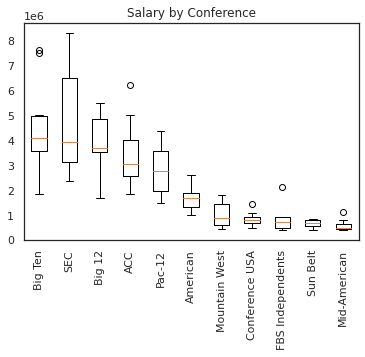

In [198]:
# boxplots of schoolpay by conference
BigTen = main[main['Conference'] == 'Big Ten']
SEC = main[main['Conference'] == 'SEC' ]
Big12 = main[main['Conference'] == 'Big 12' ]
ACC = main[main['Conference'] == 'ACC' ]
Pac12 = main[main['Conference'] == 'Pac-12' ]
American = main[main['Conference'] == 'American' ]
MountainWest = main[main['Conference'] == 'Mountain West' ]
ConferenceUSA = main[main['Conference'] == 'Conference USA' ]
FBSIndependents = main[main['Conference'] == 'FBS Independents' ]
SunBelt = main[main['Conference'] == 'Sun Belt' ]
MidAmerican = main[main['Conference'] == 'Mid-American' ]

data = [BigTen['SchoolPay'], SEC['SchoolPay'], 
    Big12['SchoolPay'], ACC['SchoolPay'], 
    Pac12['SchoolPay'], American['SchoolPay'], 
    MountainWest['SchoolPay'], ConferenceUSA['SchoolPay'],
    FBSIndependents['SchoolPay'], SunBelt['SchoolPay'],
    MidAmerican['SchoolPay']]

ordered_conference_names = ['Big Ten', 'SEC', 'Big 12', 'ACC', 'Pac-12', 'American', 'Mountain West',
                            'Conference USA', 'FBS Independents', 'Sun Belt', 'Mid-American']

fig, axis = plt.subplots()
#axis.set_xlabel('Conference')
# axis.set_ylabel('SchoolPay')
conference_plot = plt.boxplot(data, sym='o', vert=1, whis=1.5)
plt.setp(conference_plot['boxes'], color = 'black')    
plt.setp(conference_plot['whiskers'], color = 'black')    
plt.setp(conference_plot['fliers'], color = 'black', marker = 'o')
axis.set_xticklabels(ordered_conference_names)
plt.xticks(rotation=90)
plt.title("Salary by Conference")
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


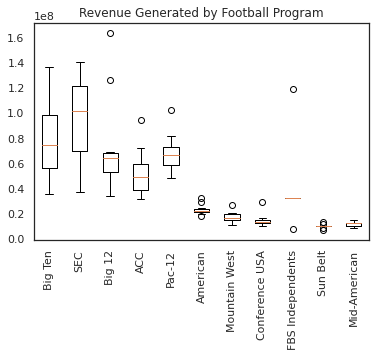

In [197]:
# boxplots of schoolpay by conference
BigTen = main[main['Conference'] == 'Big Ten']
SEC = main[main['Conference'] == 'SEC' ]
Big12 = main[main['Conference'] == 'Big 12' ]
ACC = main[main['Conference'] == 'ACC' ]
Pac12 = main[main['Conference'] == 'Pac-12' ]
American = main[main['Conference'] == 'American' ]
MountainWest = main[main['Conference'] == 'Mountain West' ]
ConferenceUSA = main[main['Conference'] == 'Conference USA' ]
FBSIndependents = main[main['Conference'] == 'FBS Independents' ]
SunBelt = main[main['Conference'] == 'Sun Belt' ]
MidAmerican = main[main['Conference'] == 'Mid-American' ]

data = [BigTen['Revenues'], SEC['Revenues'], 
    Big12['Revenues'], ACC['Revenues'], 
    Pac12['Revenues'], American['Revenues'], 
    MountainWest['Revenues'], ConferenceUSA['Revenues'],
    FBSIndependents['Revenues'], SunBelt['Revenues'],
    MidAmerican['Revenues']]

ordered_conference_names = ['Big Ten', 'SEC', 'Big 12', 'ACC', 'Pac-12', 'American', 'Mountain West',
                            'Conference USA', 'FBS Independents', 'Sun Belt', 'Mid-American']

fig, axis = plt.subplots()
# axis.set_xlabel('Conference')
# axis.set_ylabel('Revenue')
conference_plot = plt.boxplot(data, sym='o', vert=1, whis=1.5)
plt.setp(conference_plot['boxes'], color = 'black')    
plt.setp(conference_plot['whiskers'], color = 'black')    
plt.setp(conference_plot['fliers'], color = 'black', marker = 'o')
axis.set_xticklabels(ordered_conference_names)
plt.xticks(rotation=90)
plt.title("Revenue Generated by Football Program")
plt.show()

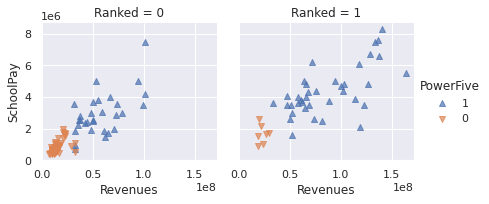

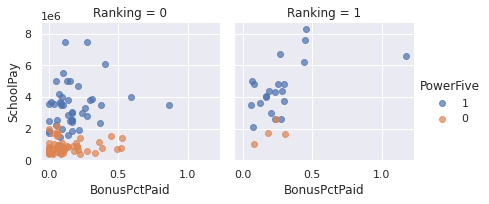

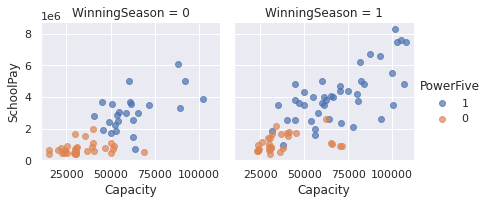

In [133]:
# scatterplots for various combinations of variables
# code from week 3 asynch

sns.set(style="darkgrid")

g = sns.FacetGrid(main, col="Ranked", hue="PowerFive", 
                  hue_order=[1, 0],
                  hue_kws=dict(marker=["^", "v"]))
g.map(plt.scatter, "Revenues", "SchoolPay", alpha=.7)
g.add_legend();
plt.show()

g = sns.FacetGrid(main, col="Ranking", hue="PowerFive",
                hue_order=[1, 0],)
g.map(plt.scatter, "BonusPctPaid", "SchoolPay", alpha=.7)
g.add_legend();
plt.show()

g = sns.FacetGrid(main, col="WinningSeason", hue="PowerFive",
                hue_order=[1, 0],)
g.map(plt.scatter, "Capacity", "SchoolPay", alpha=.7)
g.add_legend();
plt.show()

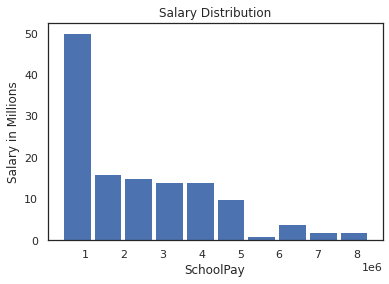

In [200]:
# histogram of attendance
# code from asynch week 3

plt.hist(main['SchoolPay'], density= False, stacked = False, rwidth = .9)
plt.title("Salary Distribution")
plt.xlabel('SchoolPay')
plt.ylabel('Salary in Millions')

plt.show()

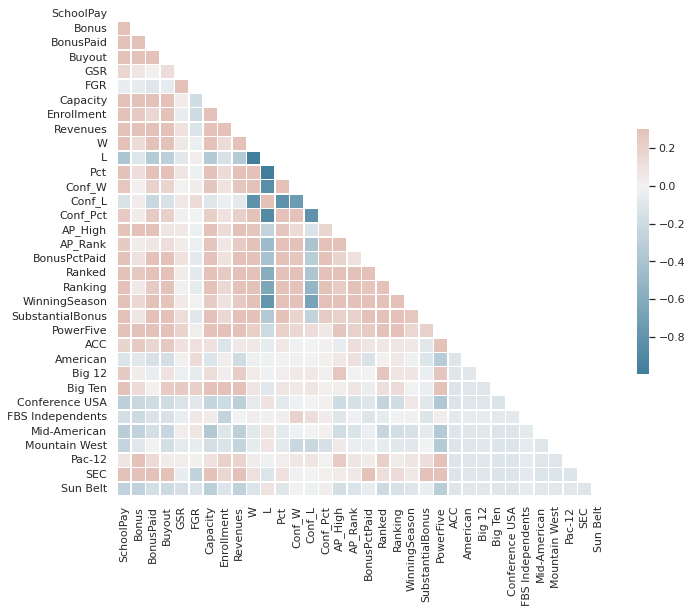

In [141]:
# code from week3 asynch
# correlation matrix
sns.set_theme(style="white")
corr = main.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

0           Troy Calhoun
1           Terry Bowden
2             Nick Saban
3             Bill Clark
4      Scott Satterfield
             ...        
123       Dana Holgorsen
124     Mike Sanford Jr.
125           Tim Lester
126          Paul Chryst
127           Craig Bohl
Name: Coach, Length: 128, dtype: object

# modeling

In [144]:
# code from week 3 async
# employ training-and-test regimen for model validation
np.random.seed(24)
main['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(main))
main_train = main[main['runiform'] >= 0.33]
main_test = main[main['runiform'] < 0.33]
# check training data frame
print('\nmain_train data frame (rows, columns): ',main_train.shape)
print(main_train.head())
# check test data frame
print('\nmain_test data frame (rows, columns): ',main_test.shape)
print(main_test.head())

# specify a simple model
model_1 = str('SchoolPay ~ BonusPctPaid + FGR + Capacity + Enrollment + Revenues + Pct + Ranked + PowerFive')

# fit the model to the training set
train_model_fit = smf.ols(model_1, data = main_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
main_train['predict_pay'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
main_test['predict_pay'] = train_model_fit.predict(main_test)



main_train data frame (rows, columns):  (93, 38)
              School     Conference              Coach  SchoolPay    Bonus  \
0          Air Force  Mountain West       Troy Calhoun     885000   247000   
1              Akron   Mid-American       Terry Bowden     411000   225000   
2            Alabama            SEC         Nick Saban    8307000  1100000   
4  Appalachian State       Sun Belt  Scott Satterfield     712500   295000   
5            Arizona         Pac-12       Kevin Sumlin    1600000  2025000   

   BonusPaid    Buyout   GSR   FGR  Capacity  Enrollment   Revenues   W  L  \
0      50000   1476060  0.89  0.89     52237        4237   16823588   5  7   
1      50000    688500  0.79  0.76     30000       19200   12354872   7  7   
2     500000  33600000  0.86  0.65    101821       38500  140831439  13  1   
4     145000   2160417  0.78  0.60     24150       19100   10198918   9  4   
5     279167  10000000  0.73  0.55     56037       45200   51865116   7  6   

    Pct  Con

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [153]:
# code from week 3 async
# model 2
# using each conference dummy variable instead of power5
# employ training-and-test regimen for model validation
np.random.seed(24)
main = main.rename(columns = {'Big Ten' : 'BigTen', 'Mountain West' : 'MountainWest', 'Mid-American' : 'MidAmerican', 'Conference USA' : 'ConferenceUSA',
       'Sun Belt' : 'SunBelt', 'Pac-12' : 'Pac12', 'FBS Independents' : 'FBSIndependents', 'Big 12' : 'Big12'})
main['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(main))
main_train = main[main['runiform'] >= 0.33]
main_test = main[main['runiform'] < 0.33]
# check training data frame
print('\nmain_train data frame (rows, columns): ',main_train.shape)
print(main_train.head())
# check test data frame
print('\nmain_test data frame (rows, columns): ',main_test.shape)
print(main_test.head())

# specify a simple model
model_2 = str('SchoolPay ~ BonusPctPaid + FGR + Capacity + Enrollment + Revenues + Pct + BigTen + MountainWest + MidAmerican + ConferenceUSA + SunBelt + Pac12 + FBSIndependents + Big12 + SEC + ACC + American')
# fit the model to the training set
train_model_fit = smf.ols(model_2, data = main_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
main_train['predict_pay'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
main_test['predict_pay'] = train_model_fit.predict(main_test)



main_train data frame (rows, columns):  (93, 38)
              School     Conference              Coach  SchoolPay    Bonus  \
0          Air Force  Mountain West       Troy Calhoun     885000   247000   
1              Akron   Mid-American       Terry Bowden     411000   225000   
2            Alabama            SEC         Nick Saban    8307000  1100000   
4  Appalachian State       Sun Belt  Scott Satterfield     712500   295000   
5            Arizona         Pac-12       Kevin Sumlin    1600000  2025000   

   BonusPaid    Buyout   GSR   FGR  Capacity  Enrollment   Revenues   W  L  \
0      50000   1476060  0.89  0.89     52237        4237   16823588   5  7   
1      50000    688500  0.79  0.76     30000       19200   12354872   7  7   
2     500000  33600000  0.86  0.65    101821       38500  140831439  13  1   
4     145000   2160417  0.78  0.60     24150       19100   10198918   9  4   
5     279167  10000000  0.73  0.55     56037       45200   51865116   7  6   

    Pct  Con

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [154]:
# code from week 3 async
# model 3
# using wins instead of pct, power5 instead of each conference
np.random.seed(24)
main['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(main))
main_train = main[main['runiform'] >= 0.33]
main_test = main[main['runiform'] < 0.33]
# check training data frame
print('\nmain_train data frame (rows, columns): ',main_train.shape)
print(main_train.head())
# check test data frame
print('\nmain_test data frame (rows, columns): ',main_test.shape)
print(main_test.head())

# specify a simple model
model_3 = str('SchoolPay ~ BonusPctPaid + FGR + Capacity + Enrollment + Revenues + W + Ranked + PowerFive')
# fit the model to the training set
train_model_fit = smf.ols(model_3, data = main_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
main_train['predict_pay'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
main_test['predict_pay'] = train_model_fit.predict(main_test)


main_train data frame (rows, columns):  (93, 38)
              School     Conference              Coach  SchoolPay    Bonus  \
0          Air Force  Mountain West       Troy Calhoun     885000   247000   
1              Akron   Mid-American       Terry Bowden     411000   225000   
2            Alabama            SEC         Nick Saban    8307000  1100000   
4  Appalachian State       Sun Belt  Scott Satterfield     712500   295000   
5            Arizona         Pac-12       Kevin Sumlin    1600000  2025000   

   BonusPaid    Buyout   GSR   FGR  Capacity  Enrollment   Revenues   W  L  \
0      50000   1476060  0.89  0.89     52237        4237   16823588   5  7   
1      50000    688500  0.79  0.76     30000       19200   12354872   7  7   
2     500000  33600000  0.86  0.65    101821       38500  140831439  13  1   
4     145000   2160417  0.78  0.60     24150       19100   10198918   9  4   
5     279167  10000000  0.73  0.55     56037       45200   51865116   7  6   

    Pct  Con

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [155]:
# code from week 3 async
# model 4
# using wins, power5, Ranking instead of Ranked
np.random.seed(24)
main['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(main))
main_train = main[main['runiform'] >= 0.33]
main_test = main[main['runiform'] < 0.33]
# check training data frame
print('\nmain_train data frame (rows, columns): ',main_train.shape)
print(main_train.head())
# check test data frame
print('\nmain_test data frame (rows, columns): ',main_test.shape)
print(main_test.head())

# specify a simple model
model_4 = str('SchoolPay ~ BonusPctPaid + FGR + Capacity + Enrollment + Revenues + W + Ranking + PowerFive')
# fit the model to the training set
train_model_fit = smf.ols(model_4, data = main_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
main_train['predict_pay'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
main_test['predict_pay'] = train_model_fit.predict(main_test)


main_train data frame (rows, columns):  (93, 38)
              School     Conference              Coach  SchoolPay    Bonus  \
0          Air Force  Mountain West       Troy Calhoun     885000   247000   
1              Akron   Mid-American       Terry Bowden     411000   225000   
2            Alabama            SEC         Nick Saban    8307000  1100000   
4  Appalachian State       Sun Belt  Scott Satterfield     712500   295000   
5            Arizona         Pac-12       Kevin Sumlin    1600000  2025000   

   BonusPaid    Buyout   GSR   FGR  Capacity  Enrollment   Revenues   W  L  \
0      50000   1476060  0.89  0.89     52237        4237   16823588   5  7   
1      50000    688500  0.79  0.76     30000       19200   12354872   7  7   
2     500000  33600000  0.86  0.65    101821       38500  140831439  13  1   
4     145000   2160417  0.78  0.60     24150       19100   10198918   9  4   
5     279167  10000000  0.73  0.55     56037       45200   51865116   7  6   

    Pct  Con

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [158]:
# code from week 3 async
# model 5
# paring down to the significant or at least lower p-value variables
np.random.seed(24)
main['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(main))
main_train = main[main['runiform'] >= 0.33]
main_test = main[main['runiform'] < 0.33]
# check training data frame
print('\nmain_train data frame (rows, columns): ',main_train.shape)
print(main_train.head())
# check test data frame
print('\nmain_test data frame (rows, columns): ',main_test.shape)
print(main_test.head())

# specify a simple model
model_5 = str('SchoolPay ~ BonusPctPaid + Enrollment + Revenues + W + Ranked + PowerFive')
# fit the model to the training set
train_model_fit = smf.ols(model_5, data = main_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
main_train['predict_pay'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
main_test['predict_pay'] = train_model_fit.predict(main_test)


main_train data frame (rows, columns):  (93, 38)
              School     Conference              Coach  SchoolPay    Bonus  \
0          Air Force  Mountain West       Troy Calhoun     885000   247000   
1              Akron   Mid-American       Terry Bowden     411000   225000   
2            Alabama            SEC         Nick Saban    8307000  1100000   
4  Appalachian State       Sun Belt  Scott Satterfield     712500   295000   
5            Arizona         Pac-12       Kevin Sumlin    1600000  2025000   

   BonusPaid    Buyout   GSR   FGR  Capacity  Enrollment   Revenues   W  L  \
0      50000   1476060  0.89  0.89     52237        4237   16823588   5  7   
1      50000    688500  0.79  0.76     30000       19200   12354872   7  7   
2     500000  33600000  0.86  0.65    101821       38500  140831439  13  1   
4     145000   2160417  0.78  0.60     24150       19100   10198918   9  4   
5     279167  10000000  0.73  0.55     56037       45200   51865116   7  6   

    Pct  Con

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [161]:
# code from week 3 async
# model 6
# only using significant p-value variables
np.random.seed(24)
main['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(main))
main_train = main[main['runiform'] >= 0.33]
main_test = main[main['runiform'] < 0.33]
# check training data frame
print('\nmain_train data frame (rows, columns): ',main_train.shape)
print(main_train.head())
# check test data frame
print('\nmain_test data frame (rows, columns): ',main_test.shape)
print(main_test.head())

# specify a simple model
model_6 = str('SchoolPay ~ BonusPctPaid + Revenues + Enrollment + PowerFive')
# fit the model to the training set
train_model_fit = smf.ols(model_6, data = main_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
main_train['predict_pay'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
main_test['predict_pay'] = train_model_fit.predict(main_test)


main_train data frame (rows, columns):  (93, 38)
              School     Conference              Coach  SchoolPay    Bonus  \
0          Air Force  Mountain West       Troy Calhoun     885000   247000   
1              Akron   Mid-American       Terry Bowden     411000   225000   
2            Alabama            SEC         Nick Saban    8307000  1100000   
4  Appalachian State       Sun Belt  Scott Satterfield     712500   295000   
5            Arizona         Pac-12       Kevin Sumlin    1600000  2025000   

   BonusPaid    Buyout   GSR   FGR  Capacity  Enrollment   Revenues   W  L  \
0      50000   1476060  0.89  0.89     52237        4237   16823588   5  7   
1      50000    688500  0.79  0.76     30000       19200   12354872   7  7   
2     500000  33600000  0.86  0.65    101821       38500  140831439  13  1   
4     145000   2160417  0.78  0.60     24150       19100   10198918   9  4   
5     279167  10000000  0.73  0.55     56037       45200   51865116   7  6   

    Pct  Con

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [186]:
# code from week 3 async
# model 7
# using conferences instead of powerfive so can answer big ten question
# and then just bonuspctpaid, revenues

np.random.seed(24)
main = main.rename(columns = {'Big Ten' : 'BigTen', 'Mountain West' : 'MountainWest', 'Mid-American' : 'MidAmerican', 'Conference USA' : 'ConferenceUSA',
       'Sun Belt' : 'SunBelt', 'Pac-12' : 'Pac12', 'FBS Independents' : 'FBSIndependents', 'Big 12' : 'Big12'})
main['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(main))
main_train = main[main['runiform'] >= 0.33]
main_test = main[main['runiform'] < 0.33]
# check training data frame
print('\nmain_train data frame (rows, columns): ',main_train.shape)
print(main_train.head())
# check test data frame
print('\nmain_test data frame (rows, columns): ',main_test.shape)
print(main_test.head())

# specify a simple model
model_7 = str('SchoolPay ~ BonusPctPaid + Revenues + BigTen + MountainWest + MidAmerican + ConferenceUSA + SunBelt + Pac12 + FBSIndependents + Big12 + SEC + ACC + American')
# fit the model to the training set
# fit the model to the training set
train_model_fit = smf.ols(model_7, data = main_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
main_train['predict_pay'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
main_test['predict_pay'] = train_model_fit.predict(main_test)


main_train data frame (rows, columns):  (93, 38)
              School     Conference              Coach  SchoolPay    Bonus  \
0          Air Force  Mountain West       Troy Calhoun     885000   247000   
1              Akron   Mid-American       Terry Bowden     411000   225000   
2            Alabama            SEC         Nick Saban    8307000  1100000   
4  Appalachian State       Sun Belt  Scott Satterfield     712500   295000   
5            Arizona         Pac-12       Kevin Sumlin    1600000  2025000   

   BonusPaid    Buyout   GSR   FGR  Capacity  Enrollment   Revenues   W  L  \
0      50000   1476060  0.89  0.89     52237        4237   16823588   5  7   
1      50000    688500  0.79  0.76     30000       19200   12354872   7  7   
2     500000  33600000  0.86  0.65    101821       38500  140831439  13  1   
4     145000   2160417  0.78  0.60     24150       19100   10198918   9  4   
5     279167  10000000  0.73  0.55     56037       45200   51865116   7  6   

    Pct  Con

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# final model

In [164]:
# code from week 3 async
# model 8, final model
# only using less than 0.05 p-values now
np.random.seed(24)
main['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(main))
main_train = main[main['runiform'] >= 0.33]
main_test = main[main['runiform'] < 0.33]
# check training data frame
print('\nmain_train data frame (rows, columns): ',main_train.shape)
print(main_train.head())
# check test data frame
print('\nmain_test data frame (rows, columns): ',main_test.shape)
print(main_test.head())

# specify a simple model
model_8 = str('SchoolPay ~ BonusPctPaid + Revenues + PowerFive')
# fit the model to the training set
train_model_fit = smf.ols(model_8, data = main_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
main_train['predict_pay'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
main_test['predict_pay'] = train_model_fit.predict(main_test)


main_train data frame (rows, columns):  (93, 38)
              School     Conference              Coach  SchoolPay    Bonus  \
0          Air Force  Mountain West       Troy Calhoun     885000   247000   
1              Akron   Mid-American       Terry Bowden     411000   225000   
2            Alabama            SEC         Nick Saban    8307000  1100000   
4  Appalachian State       Sun Belt  Scott Satterfield     712500   295000   
5            Arizona         Pac-12       Kevin Sumlin    1600000  2025000   

   BonusPaid    Buyout   GSR   FGR  Capacity  Enrollment   Revenues   W  L  \
0      50000   1476060  0.89  0.89     52237        4237   16823588   5  7   
1      50000    688500  0.79  0.76     30000       19200   12354872   7  7   
2     500000  33600000  0.86  0.65    101821       38500  140831439  13  1   
4     145000   2160417  0.78  0.60     24150       19100   10198918   9  4   
5     279167  10000000  0.73  0.55     56037       45200   51865116   7  6   

    Pct  Con

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# predictions

In [194]:
# predictions
# what should syracuse coach be paid

# coefficients
intercept = 265900
BonusPctPaid = 1604000
Revenues = 0.0315
PowerFive = 810400

# syracuse data
main[main.School == 'Syracuse']
# 101
#for ind, column in enumerate(main.columns):
 #   print(ind, column)
# BonusPctPaid: 20
# Revenues: 11
# PowerFive: 25

values = main.iloc[101, [20,11,25]]

recommended_salary = intercept + BonusPctPaid*values[0] + Revenues*values[1] + PowerFive*values[2]
recommended_salary
# 2750960.4122089553
# so approximatley 2.75 million

# the actual pay in the data is
# 2401206
# approximately 2.4 million

# what would his salary be in the big east?
# we can't make predictions outside the data we sampled
# big east doesn't exist anymore so this would be extrapolation
# however since big east was a power conference, we can conjecture that, assuming we ran this model on data from before the big east broke up
# and power conference was found to be signficant, we can assume his pay would be the same

# what would his salary be in the big ten?
# the same

# however using the model that changes out powerfive for each conference you could find slight differences in what he would be paid for ACC vs Big Ten

Intercept = 745500
BonusPctPaid = 1308000
Revenues = 0.0281
BigTen  = 957100
ACC = 981300

ACC_salary = Intercept + BonusPctPaid*values[0] + Revenues*values[1] + BigTen*0 + ACC*1
print(ACC_salary)
# 3200072.285271642
# 3.200 million
BigTen_salary = Intercept + BonusPctPaid*values[0] + Revenues*values[1] + BigTen*1 + ACC*0
BigTen_salary
# 3175872.285271642
# 3.176 million

# personally though I don't like this model because some of the conferences end up not being statistically significant


3200072.285271642


3175872.285271642

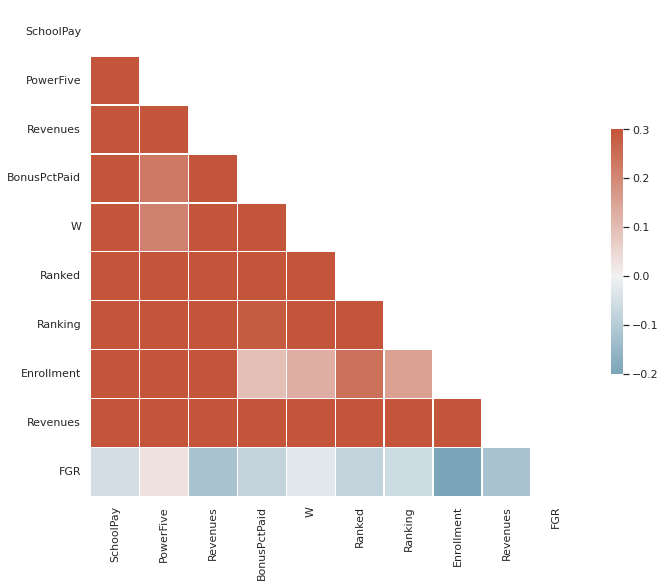

In [209]:
# heat map of variables of interest

#for ind, column in enumerate(main.columns):
 #   print(ind, column)
# [25, 3, 20, 11, 12, 21, 22, 10, 8]

main_interest = main[['SchoolPay', 'PowerFive', 'Revenues', 'BonusPctPaid', 'W', 'Ranked', 'Ranking', 'Enrollment', 'Revenues', 'FGR']]
# code from week3 asynch
# correlation matrix

sns.set_theme(style="white")
corr = main_interest.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# old code, not part of formal submission, just saving to review later
# sort of captures how i figured out refining my matching functions
# may or may not be able to improve functions by looking over this code later

In [ ]:
# import the data
grad_rates = pd.read_csv('grad_rates.csv')
confs = grad_rates['Conference'].sort_values().unique()

# convert FBS conference names to 'standard' names in the master list
confs_interest = [confs[0], confs[1], confs[2], confs[5], confs[7], confs[9], confs[10], confs[13], confs[16], confs[19], confs[23]]
master_confs = []
master_confs = ['American', 'ACC', 'Big 12', 'Big Ten', 'Conference USA', 'FBS Independents'
, 'Mid-American', 'Mountain West', 'Pac-12', 'SEC', 'Sun Belt']

confs_dict = {}
for i in range(0, len(confs_interest)):
  confs_dict[confs_interest[i]] = master_confs[i]

for i in range(0,len(grad_rates['Conference'])):
  if grad_rates['Conference'][i] in confs_dict.keys():
    grad_rates['Conference'][i] = confs_dict[grad_rates['Conference'][i]]

# subset to only include FBS conferences
grad_rates = grad_rates[grad_rates['Conference'].isin(master_confs)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# fuzzy matching on school name

test = []
for ind in coach.index:
  query = coach['School'][ind]
  choices = grad_rates['School']
  match = process.extractOne(query, choices)
  match = (ind, ) + match
  test.append(match)

In [ ]:
# make unique list function
def unique(list1):
 
    # initialize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return(unique_list)

In [ ]:
# make list of only schools
test_schools = []
for i in test:
  test_schools.append(i[1])

In [ ]:
test_unique = unique(test_schools)
len(test_unique)

122

In [ ]:
# make list of duplicates
import collections
duplicates = ([item for item, count in collections.Counter(test_schools).items() if count > 1])
duplicates


['Arkansas State ',
 'Colorado State ',
 'Georgia Southern ',
 ' Houston',
 'Middle Tennessee State ',
 'North Carolina State ',
 ' North Texas']

In [ ]:
# return additional information about duplicates

duplicate_indices = []
for i in test:
  if i[1] in duplicates:
    duplicate_indices.append([i[2], i[0], coach['School'][i[0]], i[1], i[3]])
for i in duplicate_indices:
  if i[0] == 100:
    duplicate_indices.remove(i)
indices = []
for i in test:
  indices.append([i[0], coach['School'][i[0]], i[1], i[3]])
duplicate_indices

[[90, 7, 'Arkansas', 'Arkansas State ', 11],
 [90, 25, 'Colorado', 'Colorado State ', 43],
 [100, 37, 'Georgia Southern', 'Georgia Southern ', 70],
 [60, 55, 'LSU', 'Georgia Southern ', 70],
 [95, 64, 'Middle Tennessee', 'Middle Tennessee State ', 117],
 [95, 75, 'North Carolina', 'North Carolina State ', 142],
 [100, 77, 'North Texas', ' North Texas', 145],
 [60, 98, 'USC', ' Houston', 80],
 [90, 103, 'Tennessee', 'Middle Tennessee State ', 117],
 [90, 104, 'Texas', ' North Texas', 145]]

In [ ]:
# look at borderline cases
borderline = []
for i in duplicate_indices:
  if i[0] > 90:
    borderline.append(i)
borderline

[[100, 37, 'Georgia Southern', 'Georgia Southern ', 70],
 [95, 64, 'Middle Tennessee', 'Middle Tennessee State ', 117],
 [95, 75, 'North Carolina', 'North Carolina State ', 142],
 [100, 77, 'North Texas', ' North Texas', 145]]

In [ ]:
# make function to remove the correctly identified items
def remove_positive(indices, borderline_list, duplicate_list):
  for i in indices:
    duplicate_list.remove(borderline_list[i])

In [ ]:
remove_positive([0, 1, 3], borderline, duplicate_indices)

In [ ]:
# so this can be used to see if there are any mistkaes that AREN't duplicates
# check too if the 100s are all correct
'''
potential_errors = []
for i in test:
  if i[2] != 100:
    potential_errors.append(i)
potential_errors

potential_error_info = []
for i in test:
  if i in potential_errors:
    potential_error_info.append([i[2], i[0], coach['School'][i[0]], i[1], i[3]])

indices = []
for i in test:
  indices.append([i[0], coach['School'][i[0]], i[1], i[3]])
potential_error_info

for i in potential_error_info:
  if i not in duplicate_indices:
    print(i)
'''


[90, 17, 'Buffalo', ' at Buffalo, the State  New York', 26]
[90, 18, 'California', ' California, Berkeley', 31]
[90, 21, 'Charlotte', 'The  North Carolina at Charlotte', 130]
[90, 40, 'Hawaii', ' Hawaii, Manoa', 77]
[90, 42, 'Illinois', ' Illinois Urbana-Champaign', 85]
[90, 43, 'Indiana', 'Indiana , Bloomington', 87]
[95, 52, 'Louisiana-Lafayette', ' Louisiana at Lafayette', 196]
[90, 57, 'Maryland', ' Maryland, College Park', 107]
[90, 58, 'Massachusetts', ' Massachusetts, Amherst', 108]
[83, 60, 'Miami (Fla.)', ' Miami (Florida)', 114]
[96, 61, 'Miami (Ohio)', 'Miami  (Ohio)', 113]
[95, 64, 'Middle Tennessee', 'Middle Tennessee State ', 117]
[90, 65, 'Minnesota', ' Minnesota, Twin Cities', 118]
[90, 68, 'Missouri', ' Missouri, Columbia', 122]
[90, 70, 'Nebraska', ' Nebraska, Lincoln', 131]
[95, 82, 'Ohio State', 'The Ohio State ', 154]
[90, 92, 'Rutgers', 'Rutgers, The State  New Jersey, New Brunswick', 172]
[90, 96, 'South Carolina', ' South Carolina, Columbia', 182]
[95, 100, 'Sou

In [ ]:
# put correct index and school name
corrections = []
corrections = [12, 44, 101, 129,  188, 206, 212]
grad_rates['School'][corrections]


12           Arkansas, Fayetteville
44                Colorado, Boulder
101                Louisiana State 
129     North Carolina, Chapel Hill
188             Southern California
206            Tennessee, Knoxville
212                 Texas at Austin
Name: School, dtype: object

In [ ]:
errors = []
for i in range(0, len(duplicate_indices)):
  errors.append([duplicate_indices[i][1], duplicate_indices[i][2], grad_rates['School'][corrections[i]], corrections[i]])
# at this point I need to make these into dataframes so it's easy to compare

errors
# the next step is to swap out the incorrect indices
# then change the names in the grad rates
# then merge
df_mapping = pd.DataFrame(indices)
df_errors = pd.DataFrame(errors)
df_mapping[0][df_errors[0]]
df_errors

,0,1,2,3
0,7,Arkansas,"Arkansas, Fayetteville",12
1,25,Colorado,"Colorado, Boulder",44
2,55,LSU,Louisiana State,101
3,75,North Carolina,"North Carolina, Chapel Hill",129
4,98,USC,Southern California,188
5,103,Tennessee,"Tennessee, Knoxville",206
6,104,Texas,Texas at Austin,212


In [ ]:
# swap out name and index for mistaken schools
for i in range(0, len(df_mapping[0][df_errors[0]])):
  # the print comments were to see how iteration was working
  # print(df_mapping[0][df_errors[0][i]])
  # print([df_errors[1][i]])
  df_mapping[2][df_errors[0][i]] = df_errors[2][i] 
  df_mapping[3][df_errors[0][i]] = df_errors[3][i] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
# eliminate schools not in coaches df
grad_rates = grad_rates[grad_rates['School'].isin(df_mapping[2])]

In [ ]:
# change school names
df_mapping = df_mapping.sort_values(by = 2)
grad_rates = grad_rates.sort_values(by = 'School')
df_mapping = df_mapping.drop(columns = [0,3])
df_mapping = df_mapping.rename(columns = {1: 'Coach_School', 2: 'School'})

In [ ]:
# see if columns are identical
df_mapping['School'].reset_index(drop=True).equals(grad_rates['School'].reset_index(drop=True))

True

In [ ]:
# grad rates now has the proper names and conferences and is in same order as coach, they can be merged
grad_rates = grad_rates.reset_index(drop = True)
df_mapping = df_mapping.reset_index(drop = True)
grad_rates['School'] = df_mapping['Coach_School']
grad_rates = grad_rates.sort_values(by = 'School')
grad_rates = grad_rates.reset_index(drop = True)
grad_rates

,School,Conference,State,GSR,FGR
0,Air Force,Mountain West,CO,0.89,0.00
1,Akron,Mid-American,OH,0.79,0.76
2,Alabama,SEC,AL,0.86,0.65
3,Alabama at Birmingham,Conference USA,AL,0.69,0.42
4,Appalachian State,Sun Belt,NC,0.78,0.60
...,...,...,...,...,...
124,West Virginia,Big 12,WV,0.74,0.60
125,Western Kentucky,Conference USA,KY,0.74,0.57
126,Western Michigan,Mid-American,MI,0.74,0.40
127,Wisconsin,Big Ten,WI,0.90,0.81


In [ ]:
# testing to make sure this regex method for converting string to list works

# test = re.sub(',' , '' , col[1])
# test = re.sub('\n', ',' , test)
# test = test[1:-1]
# test = test.split(",")
#test

In [ ]:
# function for changing conferences
def confs_fix(inputlist, df):
    fbs_confs = ['American', 'ACC', 'Big 12', 'Big Ten', 'Conference USA', 'FBS Independents'
     , 'Mid-American', 'Mountain West', 'Pac-12', 'SEC', 'Sun Belt']
    fbs_confs_dict = {}
    for i in range(0, len(inputlist)):
      fbs_confs_dict[inputlist[i]] = fbs_confs[i]
    for i in range(0,len(df['Conference'])):
      if df['Conference'][i] in fbs_confs_dict.keys():
          df['Conference'][i] = fbs_confs_dict[df['Conference'][i]]
    df = df[df['Conference'].isin(fbs_confs)]
    print(df['Conference'].unique(), len(df['Conference'].unique()))
    return(df)

In [ ]:
# create list of conferences in stadium dataframe
confs_input = unique(stadiums['Conference'].sort_values())

In [ ]:
stadiums = confs_fix(confs_input, stadiums)

['Big Ten' 'SEC' 'Big 12' 'Pac-12' 'ACC' 'FBS Independents'
 'Conference USA' 'Mountain West' 'Mid-American' 'American' 'Sun Belt'] 11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:

# subsetting example
# coach[coach.School == 'Southern California']

131

In [ ]:
# fuzzy matching function
# input the "matched against" df first, then the original second
# put the names of columns to use here
# this assumes coach will be used second, and the columns 'School' and 'Conference' in that order

def match_names(df1, df2, col1, col2):
  df1['JoinCol'] = df1[col1] + ', ' + df1[col2]
  df2['JoinCol'] = df2[col1] + ', ' + df2[col2]
  results = []
  for ind in df2.index:
    query = df2['JoinCol'][ind]
    choices = df1['JoinCol']
    match = process.extractOne(query, choices)
    match = (ind, ) + match
    results.append(match)
  match_info = []
  for i in results:
    match_info.append([i[2], i[0], df2[col1][i[0]], df1[col1][i[3]], i[3]])
  return(match_info)  

In [ ]:
# older version of function; figured out how to combine multiple steps
'''
def match_error_identify(match_results):
  potential_errors = []
  for i in match_results:
    if i[0] != 100:
      potential_errors.append(i)
  return(potential_errors)
  '''

'\ndef match_error_identify(match_results):\n  potential_errors = []\n  for i in match_results:\n    if i[0] != 100:\n      potential_errors.append(i)\n  return(potential_errors)\n  '

In [ ]:
# this function finds all matches with less than 100 score
# and all matches that are duplicates
# then it pares the duplicates down to only duplicates with less than 100 score
# those are certain errors, and will all be contianed in the list of
# matches with less than 100
# it then removes those from that list
# and those records are marked as potential errors, because they are either false positives
# or they are records that exist in orginal df but not target df
# returns a list with [0] holding certain errors and [1] holding potential errors

def match_error_identify(match_results, df1,df2):
  errors = []
  for i in match_results:
    if i[0] != 100:
      errors.append(i)
  # ANYTHING that is duplicated AND has a score less than 100 is incorrect
  # BUT this doesn't capture all errors, 
  #for example, records in the original dataframe that are missing in the new dataframe
  schools = []
  for i in match_results:
    schools.append(i[3])
  duplicated_schools = ([item for item, count in collections.Counter(schools).items() if count > 1])
  duplicates = []
  for i in match_results:
    if i[3] in duplicated_schools:
      duplicates.append(i)
  duplicates
  errors2 = []
  for i in duplicates:
    if i[0] != 100:
      errors2.append(i)
  # the UNION of these are certainly errors
  # everything in the duplicates will be found in the list
  # of items with less than 100 score
  # but the items NOT FOUND in the duplicates
  # which are found in the list of less than 100
  # might be errors
  potential_errors = []
  for i in errors:
    if i not in errors2:
      potential_errors.append(i)
  certain_errors  = []
  for i in errors:
    if i in errors2:
      certain_errors.append(i)
  print('', len(df2), 'records in original DF', '\n', len(df1), 'records in target DF', '\n', 
        len(certain_errors), 'certain errors, can include mismatches or records that exist in orignal df but not target df', 
        '\n', len(potential_errors), 
        'potential errors (false positives or records missing from target DF)' )
  return [certain_errors, potential_errors]

In [ ]:
matching_results = match_names(stadiums, coach, 'School', 'Conference')
potential_error = match_error_identify(matching_results, stadiums, coach)

 129 records in original DF 
 131 records in target DF 
 11 potential errors


In [ ]:
# inspect the output to identify anomalies
potential_error
# output:
'''
[[86, 3, 'Alabama at Birmingham', 'Alabama', 5],
 [85, 16, 'Brigham Young', 'BYU', 35],
 [87, 50, 'Liberty', 'BYU', 35],
 [85, 58, 'Massachusetts', 'BYU', 35],
 [95, 61, 'Miami (Ohio)', 'Ohio', 120],
 [95, 72, 'Nevada-Las Vegas', 'Nevada', 110],
 [86, 74, 'New Mexico State', 'Penn State', 1],
 [95, 76, 'North Carolina State', 'North Carolina', 36],
 [86, 106, 'Texas Christian', 'Texas A&M', 3],
 [86, 109, 'Texas-El Paso', 'Texas A&M', 3],
 [86, 110, 'Texas-San Antonio', 'Texas A&M', 3]]
 '''
# need to actually look at stadiums dataframe to find proper indice for school from coach df
# there is only one false negative here: BYU
# that can be safely removed from errors
# but first must address another issue
potential_error

[[86, 3, 'Alabama at Birmingham', 'Alabama', 5],
 [85, 16, 'Brigham Young', 'BYU', 35],
 [87, 50, 'Liberty', 'BYU', 35],
 [85, 58, 'Massachusetts', 'BYU', 35],
 [95, 61, 'Miami (Ohio)', 'Ohio', 120],
 [95, 72, 'Nevada-Las Vegas', 'Nevada', 110],
 [86, 74, 'New Mexico State', 'Penn State', 1],
 [95, 76, 'North Carolina State', 'North Carolina', 36],
 [86, 106, 'Texas Christian', 'Texas A&M', 3],
 [86, 109, 'Texas-El Paso', 'Texas A&M', 3],
 [86, 110, 'Texas-San Antonio', 'Texas A&M', 3]]

In [ ]:
# Upon inspecting stadiums df and the actual webpage, realized that for some reaosn
# liberty and TCU were not scraped from the site
# manually adding the schools now
# first make a new datframe then use append to add them as rows at the bottom
missing_dict = {'School': ['Liberty', 'Texas Christian'],
                    'Conference' : ['FBS Independents', 'Big 12'], 
                    'Capacity': [25000, 45000],
                    'JoinCol' : ['Liberty, FBS Independents', 'Texas Christian, Big 12']
                    }
missing_stadiums = pd.DataFrame.from_dict(missing_dict)
stadiums = stadiums.append(missing_stadiums, ignore_index = True)

In [ ]:
# now can rerun the matching and error function, and it shouldn't have Liberty or TCU mismatched
# and then can remove the false positive BYU
matching_results = match_names(stadiums, coach, 'School', 'Conference')
potential_error = match_error_identify(matching_results, stadiums, coach)
potential_error.remove([85, 16, 'Brigham Young', 'BYU', 35])

 129 records in original DF 
 133 records in target DF 
 9 potential errors


In [ ]:
potential_error
# output
'''
[[86, 3, 'Alabama at Birmingham', 'Alabama', 5],
 [85, 58, 'Massachusetts', 'BYU', 35],
 [95, 61, 'Miami (Ohio)', 'Ohio', 120],
 [95, 72, 'Nevada-Las Vegas', 'Nevada', 110],
 [86, 74, 'New Mexico State', 'Penn State', 1],
 [95, 76, 'North Carolina State', 'North Carolina', 36],
 [86, 109, 'Texas-El Paso', 'Texas A&M', 3],
 [86, 110, 'Texas-San Antonio', 'Texas A&M', 3]]
 '''
 # now need to find the index of the proper school on the stadiums df
 # via manual inspection, and make a list of the indice
potential_error

[[86, 3, 'Alabama at Birmingham', 'Alabama', 5],
 [85, 58, 'Massachusetts', 'BYU', 35],
 [95, 61, 'Miami (Ohio)', 'Ohio', 120],
 [95, 72, 'Nevada-Las Vegas', 'Nevada', 110],
 [86, 74, 'New Mexico State', 'Penn State', 1],
 [95, 76, 'North Carolina State', 'North Carolina', 36],
 [86, 109, 'Texas-El Paso', 'Texas A&M', 3],
 [86, 110, 'Texas-San Antonio', 'Texas A&M', 3]]

In [ ]:
# look at whole dataframe
pd.options.display.max_rows = 150
stadiums.sort_values('School')

In [ ]:
# i manually wrote the index of the proper school such as UAB and then added it to the list

'''
22  [86, 3, 'Alabama at Birmingham', 'Alabama', 5],
127 [85, 58, 'Massachusetts', 'BYU', 35],
117 [95, 61, 'Miami (Ohio)', 'Ohio', 120]
87  [95, 72, 'Nevada-Las Vegas', 'Nevada', 110],
101 [86, 74, 'New Mexico State', 'Penn State', 1],
48  [95, 76, 'North Carolina State', 'North Carolina', 36],
59  [86, 109, 'Texas-El Paso', 'Texas A&M', 3],
33  [86, 110, 'Texas-San Antonio', 'Texas A&M', 3]]
'''
proper_index = [22, 127, 117, 87, 101, 48, 59, 33]
potential_error

[[86, 3, 'Alabama at Birmingham', 'Alabama', 5],
 [85, 58, 'Massachusetts', 'BYU', 35],
 [95, 61, 'Miami (Ohio)', 'Ohio', 120],
 [95, 72, 'Nevada-Las Vegas', 'Nevada', 110],
 [86, 74, 'New Mexico State', 'Penn State', 1],
 [95, 76, 'North Carolina State', 'North Carolina', 36],
 [86, 109, 'Texas-El Paso', 'Texas A&M', 3],
 [86, 110, 'Texas-San Antonio', 'Texas A&M', 3]]

In [ ]:
# this function prepares the target dataframe to be merged
# the arguements are the outputs from previous functions as well as a numeric value for the target match column, which is 
# assumed to be to the right of the target column
# cols to drop also is a numeric input
def correct_mismatch(correct_indices, errors_list, match_results, match_col_to_sort, df1, dfcol, match_cols_to_drop):
  corrections = []
  for i in range(0, len(correct_indices)):
    corrections.append([errors_list[i][0], errors_list[i][1], errors_list[i][2], df1[dfcol][correct_indices[i]], correct_indices[i]])
  df_mapping = pd.DataFrame(match_results)
  df_corrections = pd.DataFrame(corrections)
  # swap out name and index for mistaken schools
  for i in range(0, len(df_mapping[0][df_corrections[0]])):
    df_mapping[3][df_corrections[1][i]] = df_corrections[3][i] 
    df_mapping[4][df_corrections[1][i]] = df_corrections[4][i] 
  # eliminate records from col not in original df
  df1 = df1[df1[dfcol].isin(df_mapping[3])]
  # change values in target df to match original df
  df_mapping = df_mapping.sort_values(by = 3)
  df1 = df1.sort_values(by = dfcol)
  df_mapping = df_mapping.drop(columns = match_cols_to_drop)
  df_mapping = df_mapping.rename(columns = {match_col_to_sort-1: 'OriginalDFValue', match_col_to_sort: dfcol})
  # see if columns are identical
  if df_mapping[dfcol].reset_index(drop=True).equals(df1[dfcol].reset_index(drop=True)) == True:
    # grad rates now has the proper names and conferences and is in same order as coach, they can be merged
    print('Target DF records now match orginal DF records in col of interest, and are same order; they can now be merged')
    print(len(df1), 'records')
    df1 = df1.reset_index(drop = True)
    df_mapping = df_mapping.reset_index(drop = True)
    df1[dfcol] = df_mapping[dfcol]
    df1 = df1.sort_values(by = dfcol)
    df1 = df1.reset_index(drop = True)
    return(df1)
  else:
    print('There is a mistake somewhere. The dataframes do not allign.') 

In [ ]:
stadiums = correct_mismatch(proper_index, potential_error, matching_results, 3, stadiums, 'School', [0,1,4])

Target DF records now match orginal DF records in col of interest, and are same order; they can now be merged
129 records


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# uploading revenues csv
# this came from https://graphics.wsj.com/table/NCAA_2019
# dynamic table, couldn't easily scrape it
# copied and pasted into excel, kept only School and Revenue columns, converted revenue to number
from google.colab import files
uploaded = files.upload()

Saving revenues.csv to revenues.csv


In [ ]:
# what I did before writing the functions
# now not necessary
'''
revenues = pd.read_csv('revenues.csv')
pd.options.display.max_rows = 300
revenues = revenues.rename(columns = {'Revenues' : 'Revenue'})
test = []
for ind in coach.index:
  query = coach['School'][ind]
  choices = revenues['School']
  match = process.extractOne(query, choices)
  match = (ind, ) + match
  test.append(match)
test
test_schools = []
for i in test:
  test_schools.append(i[1])
test_unique = unique(test_schools)
import collections
duplicates = ([item for item, count in collections.Counter(test_schools).items() if count > 1])
duplicates
'''

In [ ]:
# all the functions (they are defined later, this is more for my reference)
# i developed most of these after doing fuzzy matching for the first new data set

# returns a unique list, used for getting conferences

# unique(list_input)

# function for changing conferences

# confs_fix(inputlist, df)

# fuzzy matching function
# input the "matched against" df first, then the original second
# put the names of columns to use here
# this assumes coach will be used second, and the columns 'School' and 'Conference' in that order

# match_names(df1, df2, col1, col2)

# this function finds all matches with less than 100 score, and takes out the duplicates
# then returns the list
# requires the input of the match_names function
# and target and original dfs

# match_error_identify(match_results, df1,df2)

####
# between these two steps, have to identify the correct indices of the schools that are mismatched
# may have to add missing data to the target dataframe
# and also use .remove() to get rid of false negatives
####

# this function prepares the target dataframe to be merged
# the arguements are the outputs from previous functions as well as a numeric value for the target match column, which is 
# assumed to be to the right of the target column
# cols to drop also is a numeric input

# correct_mismatch(correct_indices, errors_list, match_results, match_col_to_sort, df1, dfcol, match_cols_to_drop)

In [ ]:
revenues = pd.read_csv('revenues.csv')
revenues = revenues.rename(columns = {'Revenues' : 'Revenue'})
pd.options.display.max_rows = 300
# revenues
# there are no conferences here
# the function i made requires two columns for beter matching (I tested with one column and two and two did a little better)
# however if there is only 1 column to work with, I can just enter it twice and it should be fine
matching_results = match_names(revenues, coach, 'School', 'School')
potential_errors = match_error_identify(matching_results, revenues, coach)
potential_errors
'''
[[67, 0, 'Air Force', 'Rice', 86],
 [86, 3, 'Alabama at Birmingham', 'Alabama', 2],
 [86, 4, 'Appalachian State', 'Ohio State', 1],
 [64, 9, 'Army', 'Maryland', 50],
 [58, 21, 'Charlotte', 'Arizona State', 24],
 [84, 24, 'Coastal Carolina', 'East Carolina', 78],
 [86, 37, 'Georgia Southern', 'Georgia', 5],
 [86, 38, 'Georgia State', 'Georgia', 5],
 [64, 58, 'Massachusetts', 'Syracuse', 56],
 [86, 67, 'Mississippi State', 'Ohio State', 1],
 [86, 72, 'Nevada-Las Vegas', 'Nevada', 93],
 [54, 85, 'Old Dominion', 'Ohio', 85],
 [86, 95, 'South Alabama', 'Alabama', 2],
 [67, 98, 'USC', 'UCLA', 23],
 [86, 100, 'Southern Mississippi', 'Mississippi', 21],
 [86, 107, 'Texas State', 'Texas', 0],
 [86, 109, 'Texas-El Paso', 'Texas', 0],
 [86, 110, 'Texas-San Antonio', 'Texas', 0],
 [67, 113, 'Tulane', 'UCLA', 23],
 [73, 114, 'Tulsa', 'UCLA', 23],
 [86, 123, 'Washington State', 'Ohio State', 1]]
 '''

 129 records in original DF 
 115 records in target DF 
 21 potential errors


"\n[[67, 0, 'Air Force', 'Rice', 86],\n [86, 3, 'Alabama at Birmingham', 'Alabama', 2],\n [86, 4, 'Appalachian State', 'Ohio State', 1],\n [64, 9, 'Army', 'Maryland', 50],\n [58, 21, 'Charlotte', 'Arizona State', 24],\n [84, 24, 'Coastal Carolina', 'East Carolina', 78],\n [86, 37, 'Georgia Southern', 'Georgia', 5],\n [86, 38, 'Georgia State', 'Georgia', 5],\n [64, 58, 'Massachusetts', 'Syracuse', 56],\n [86, 67, 'Mississippi State', 'Ohio State', 1],\n [86, 72, 'Nevada-Las Vegas', 'Nevada', 93],\n [54, 85, 'Old Dominion', 'Ohio', 85],\n [86, 95, 'South Alabama', 'Alabama', 2],\n [67, 98, 'USC', 'UCLA', 23],\n [86, 100, 'Southern Mississippi', 'Mississippi', 21],\n [86, 107, 'Texas State', 'Texas', 0],\n [86, 109, 'Texas-El Paso', 'Texas', 0],\n [86, 110, 'Texas-San Antonio', 'Texas', 0],\n [67, 113, 'Tulane', 'UCLA', 23],\n [73, 114, 'Tulsa', 'UCLA', 23],\n [86, 123, 'Washington State', 'Ohio State', 1]]\n "

In [ ]:
revenues.sort_values('School')

In [ ]:
# there are 14 missing records and 7 potential mismatches

#output of potential errors, going to change the index 
fixing = [[67, 0, 'Air Force', 'Rice', None],
 [86, 3, 'Alabama at Birmingham', 'Alabama', 70],
 [86, 4, 'Appalachian State', 'Ohio State', None],
 [64, 9, 'Army', 'Maryland', None],
 [58, 21, 'Charlotte', 'Arizona State', None],
 [84, 24, 'Coastal Carolina', 'East Carolina', None],
 [86, 37, 'Georgia Southern', 'Georgia', None],
 [86, 38, 'Georgia State', 'Georgia', None],
 [64, 58, 'Massachusetts', 'Syracuse', None],
 [86, 67, 'Mississippi State', 'Ohio State', 34],
 [86, 72, 'Nevada-Las Vegas', 'Nevada', 84],
 [54, 85, 'Old Dominion', 'Ohio', None],
 [86, 95, 'South Alabama', 'Alabama', None],
 [67, 98, 'USC', 'UCLA', 22],
 [86, 100, 'Southern Mississippi', 'Mississippi', 100],
 [86, 107, 'Texas State', 'Texas', None],
 [86, 109, 'Texas-El Paso', 'Texas', 91],
 [86, 110, 'Texas-San Antonio', 'Texas', None],
 [67, 113, 'Tulane', 'UCLA', None],
 [73, 114, 'Tulsa', 'UCLA', None],
 [86, 123, 'Washington State', 'Ohio State', 51]]

proper_index = []
for i in fixing:
  proper_index.append(i[4])
proper_index

[None,
 70,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 34,
 84,
 None,
 None,
 22,
 100,
 None,
 91,
 None,
 None,
 None,
 51]

In [ ]:
def correct_mismatch(correct_indices, errors_list, match_results, match_col_to_sort, df1, dfcol, match_cols_to_drop):
  corrections = []
  for i in range(0, len(correct_indices)):
    if correct_indices[i] != None:
      corrections.append([errors_list[i][0], errors_list[i][1], errors_list[i][2], df1[dfcol][correct_indices[i]], correct_indices[i]])
    else:
      corrections.append([errors_list[i][0], errors_list[i][1], errors_list[i][2], 'MISSING', correct_indices[i]])
  df_mapping = pd.DataFrame(match_results)
  df_corrections = pd.DataFrame(corrections)
  # swap out name and index for mistaken schools
  for i in range(0, len(df_mapping[0][df_corrections[0]])):
    df_mapping[3][df_corrections[1][i]] = df_corrections[3][i] 
    df_mapping[4][df_corrections[1][i]] = df_corrections[4][i] 
  # eliminate records from col not in original df
  df1 = df1[df1[dfcol].isin(df_mapping[3])]
  # change values in target df to match original df
  df_mapping = df_mapping.sort_values(by = 3)
  df1 = df1.sort_values(by = dfcol)
  df_mapping = df_mapping[df_mapping[3] != 'MISSING']
  df_mapping = df_mapping.drop(columns = match_cols_to_drop)
  df_mapping = df_mapping.rename(columns = {match_col_to_sort-1: 'OriginalDFValue', match_col_to_sort: dfcol})
  # see if columns are identical
  if df_mapping[dfcol].reset_index(drop=True).equals(df1[dfcol].reset_index(drop=True)) == True:
    # grad rates now has the proper names and conferences and is in same order as coach, they can be merged
    print('Target DF records now match orginal DF records in col of interest, and are same order; they can now be merged')
    print(len(df1), 'records')
    df1 = df1.reset_index(drop = True)
    df_mapping = df_mapping.reset_index(drop = True)
    df1[dfcol] = df_mapping[dfcol]
    df1 = df1.sort_values(by = dfcol)
    df1 = df1.reset_index(drop = True)
    return(df1)
  else:
    print('There is a mistake somewhere. The dataframes do not allign.','\nreturning mapping DF for analysis')
    return(df_mapping)

In [ ]:
def correct_mismatch(correct_indices, errors_list, match_results, match_col_to_sort, df1, dfcol, match_cols_to_drop):
  corrections = []
  for i in range(0, len(correct_indices)):
    if correct_indices[i] != None:
      corrections.append([errors_list[i][0], errors_list[i][1], errors_list[i][2], df1[dfcol][correct_indices[i]], correct_indices[i]])
    else:
      corrections.append([errors_list[i][0], errors_list[i][1], errors_list[i][2], 'MISSING', correct_indices[i]])
  df_mapping = pd.DataFrame(match_results)
  df_corrections = pd.DataFrame(corrections)
  # swap out name and index for mistaken schools
  for i in range(0, len(df_mapping[0][df_corrections[0]])):
    df_mapping[3][df_corrections[1][i]] = df_corrections[3][i] 
    df_mapping[4][df_corrections[1][i]] = df_corrections[4][i] 
  # eliminate records from col not in original df
  df1 = df1[df1[dfcol].isin(df_mapping[3])]
  # change values in target df to match original df
  df_mapping = df_mapping.sort_values(by = 3)
  df1 = df1.sort_values(by = dfcol)
  df_mapping = df_mapping[df_mapping[3] != 'MISSING']
  df_mapping = df_mapping.drop(columns = match_cols_to_drop)
  df_mapping = df_mapping.rename(columns = {match_col_to_sort-1: 'OriginalDFValue', match_col_to_sort: dfcol})
  return(df_corrections)

In [ ]:
def correct_mismatch(correct_indices, errors_list, match_results, match_col_to_sort, df1, dfcol, match_cols_to_drop):
  corrections = []
  for i in range(0, len(correct_indices)):
    if correct_indices[i] != None:
      corrections.append([errors_list[i][0], errors_list[i][1], errors_list[i][2], df1[dfcol][correct_indices[i]], correct_indices[i]])
    else:
      corrections.append([errors_list[i][0], errors_list[i][1], errors_list[i][2], 'MISSING', correct_indices[i]])
  df_mapping = pd.DataFrame(match_results)
  df_corrections = pd.DataFrame(corrections)
  return(df_mapping)

In [ ]:
df_map = correct_mismatch(proper_index, potential_errors, matching_results, 3, revenues, 'School', [0,1,4])
df_map
potential_errors
def match_error_identify(match_results, df1,df2):
  error_schools = []
  for i in match_results:
    error_schools.append(i[3])
  import collections
  errors = ([item for item, count in collections.Counter(error_schools).items() if count > 1])
  errors_info = []
  for i in match_results:
    if i[3] in errors:
      errors_info.append(i)
  # for some reason this needs to be run twice
  for i in errors_info:
    if i[0] == 100:
      errors_info.remove(i)
  # not all the matches get remove otherwise
#  for i in errors_info:
 #   if i[0] != 100:
  #    errors_info.append(i)
  print('', len(df2), 'records in original DF', '\n', len(df1), 'records in target DF', '\n', len(errors_info), 'potential errors' )
  return(error_schools)
potential_errors = match_error_identify(matching_results, revenues, coach)

errors = []
for i in matching_results:
  if i[0] != 100:
    errors.append(i)
# this ensures anything without 100 gets added to our list
schools = []
for i in matching_results:
  schools.append(i[3])
duplicated_schools = ([item for item, count in collections.Counter(schools).items() if count > 1])
dupllicates = []
for i in matching_results:
  if i[3] in duplicated_schools:
    duplicates.append(i)
errors2 = []
for i in duplicates:
  if i[0] != 100:
    errors2.append(i)
errors2

NameError: ignored

In [ ]:
# these contain possible errors
# EVERY 100 is a correct match
# but not everything less than 100 is incorrect
revenues = pd.read_csv('revenues.csv')
revenues = revenues.rename(columns = {'Revenues' : 'Revenue'})
pd.options.display.max_rows = 300
# revenues
# there are no conferences here
# the function i made requires two columns for beter matching (I tested with one column and two and two did a little better)
# however if there is only 1 column to work with, I can just enter it twice and it should be fine
matching_results = match_names(revenues, coach, 'School', 'School')

errors = []
for i in matching_results:
  if i[0] != 100:
    errors.append(i)
# ANYTHING that is duplicated AND has a score less than 100 is incorrect
# BUT this doesn't capture all errors, 
#for example, records in the original dataframe that are missing in the new dataframe
schools = []
for i in matching_results:
  schools.append(i[3])
duplicated_schools = ([item for item, count in collections.Counter(schools).items() if count > 1])
duplicates = []
for i in matching_results:
  if i[3] in duplicated_schools:
    duplicates.append(i)
duplicates
errors2 = []
for i in duplicates:
  if i[0] != 100:
    errors2.append(i)
# the UNION of these are certainly errors
# everything in the duplicates will be found in the list
# of items with less than 100 score
# but the items NOT FOUND in the duplicates
# which are found in the list of less than 100
# might be errors
potential_errors = []
for i in errors:
  if i not in errors2:
   potential_errors.append(i)
potential_errors
certain_errors  = []
for i in errors:
  if i in errors2:
    certain_errors.append(i)
certain_errors


[[67, 0, 'Air Force', 'Rice', 86],
 [86, 3, 'Alabama at Birmingham', 'Alabama', 2],
 [86, 4, 'Appalachian State', 'Ohio State', 1],
 [64, 9, 'Army', 'Maryland', 50],
 [58, 21, 'Charlotte', 'Arizona State', 24],
 [84, 24, 'Coastal Carolina', 'East Carolina', 78],
 [86, 37, 'Georgia Southern', 'Georgia', 5],
 [86, 38, 'Georgia State', 'Georgia', 5],
 [64, 58, 'Massachusetts', 'Syracuse', 56],
 [86, 67, 'Mississippi State', 'Ohio State', 1],
 [86, 72, 'Nevada-Las Vegas', 'Nevada', 93],
 [54, 85, 'Old Dominion', 'Ohio', 85],
 [86, 95, 'South Alabama', 'Alabama', 2],
 [67, 98, 'USC', 'UCLA', 23],
 [86, 100, 'Southern Mississippi', 'Mississippi', 21],
 [86, 107, 'Texas State', 'Texas', 0],
 [86, 109, 'Texas-El Paso', 'Texas', 0],
 [86, 110, 'Texas-San Antonio', 'Texas', 0],
 [67, 113, 'Tulane', 'UCLA', 23],
 [73, 114, 'Tulsa', 'UCLA', 23],
 [86, 123, 'Washington State', 'Ohio State', 1]]

In [ ]:
# this function finds all matches with less than 100 score
# and all matches that are duplicates
# then it pares the duplicates down to only duplicates with less than 100 score
# those are certain errors, and will all be contianed in the list of
# matches with less than 100
# it then removes those from that list
# and those records are marked as potential errors, because they are either false positives
# or they are records that exist in orginal df but not target df
# returns a list with [0] holding certain errors and [1] holding potential errors

def match_error_identify(match_results, df1,df2):
  errors = []
  for i in match_results:
    if i[0] != 100:
      errors.append(i)
  # ANYTHING that is duplicated AND has a score less than 100 is incorrect
  # BUT this doesn't capture all errors, 
  #for example, records in the original dataframe that are missing in the new dataframe
  schools = []
  for i in match_results:
    schools.append(i[3])
  duplicated_schools = ([item for item, count in collections.Counter(schools).items() if count > 1])
  duplicates = []
  for i in match_results:
    if i[3] in duplicated_schools:
      duplicates.append(i)
  duplicates
  errors2 = []
  for i in duplicates:
    if i[0] != 100:
      errors2.append(i)
  # the UNION of these are certainly errors
  # everything in the duplicates will be found in the list
  # of items with less than 100 score
  # but the items NOT FOUND in the duplicates
  # which are found in the list of less than 100
  # might be errors
  potential_errors = []
  for i in errors:
    if i not in errors2:
      potential_errors.append(i)
  certain_errors  = []
  for i in errors:
    if i in errors2:
      certain_errors.append(i)
  print('', len(df2), 'records in original DF', '\n', len(df1), 'records in target DF', '\n', 
        len(certain_errors), 'certain errors, can include mismatches or records that exist in orignal df but not target df', 
        '\n', len(potential_errors), 
        'potential errors, can include mismatches, records missing from target DF, OR false positives (matches marked as mismatches))' )
  return [certain_errors, potential_errors]

In [ ]:
potential_errors = match_error_identify(matching_results, revenues, coach)
certain_errors = potential_errors[0]
potential_errors = potential_errors[1]
# get potential errors
for i in range(0, len(potential_errors)):
  print(i, potential_errors[i])
# record indices of actual errors
error_indices = [1, 2, 5]

 129 records in original DF 
 115 records in target DF 
 21 certain errors, can include mismatches or records that exist in orignal df but not target df 
 7 potential errors (false positives or records missing from target DF)
0 [57, 16, 'Brigham Young', 'BYU', 59]
1 [86, 18, 'California', 'Southern California', 22]
2 [50, 50, 'Liberty', 'California Berkeley', 39]
3 [76, 60, 'Miami (Fla.)', 'Miami of Florida', 40]
4 [95, 61, 'Miami (Ohio)', 'Miami - Ohio', 105]
5 [60, 69, 'Navy', 'UNLV', 84]
6 [95, 105, 'Texas A&M', 'Texas A & M', 11]


In [ ]:
# function to remove falsely identified mismatches and create final errors list
# input is the indices of records TO KEEP as errors (from the potential errors)
# as well as the potential errors list and certain errors list
def remove_false_mismatch(indices, potential_errors, certain_errors):
  bridge = []
  for i in indices:
    bridge.append(potential_errors[i])
  errors = []
  for i in certain_errors:
    errors.append(i)
  for i in bridge:
    errors.append(i)
  return(errors)


In [ ]:
errors = remove_false_mismatch(error_indices, potential_errors, certain_errors)
# take the output of errors and change the indices to the indice of the school
# if it exists in the target DF, otherwise choose none
errors

[[67, 0, 'Air Force', 'Rice', 86],
 [86, 3, 'Alabama at Birmingham', 'Alabama', 2],
 [86, 4, 'Appalachian State', 'Ohio State', 1],
 [64, 9, 'Army', 'Maryland', 50],
 [58, 21, 'Charlotte', 'Arizona State', 24],
 [84, 24, 'Coastal Carolina', 'East Carolina', 78],
 [86, 37, 'Georgia Southern', 'Georgia', 5],
 [86, 38, 'Georgia State', 'Georgia', 5],
 [64, 58, 'Massachusetts', 'Syracuse', 56],
 [86, 67, 'Mississippi State', 'Ohio State', 1],
 [86, 72, 'Nevada-Las Vegas', 'Nevada', 93],
 [54, 85, 'Old Dominion', 'Ohio', 85],
 [86, 95, 'South Alabama', 'Alabama', 2],
 [67, 98, 'USC', 'UCLA', 23],
 [86, 100, 'Southern Mississippi', 'Mississippi', 21],
 [86, 107, 'Texas State', 'Texas', 0],
 [86, 109, 'Texas-El Paso', 'Texas', 0],
 [86, 110, 'Texas-San Antonio', 'Texas', 0],
 [67, 113, 'Tulane', 'UCLA', 23],
 [73, 114, 'Tulsa', 'UCLA', 23],
 [86, 123, 'Washington State', 'Ohio State', 1],
 [86, 18, 'California', 'Southern California', 22],
 [50, 50, 'Liberty', 'California Berkeley', 39],
 [60

In [ ]:
revenues.sort_values('School')

In [ ]:
fixing = [[67, 0, 'Air Force', 'Rice', None],
 [86, 3, 'Alabama at Birmingham', 'Alabama', 70],
 [86, 4, 'Appalachian State', 'Ohio State', None],
 [64, 9, 'Army', 'Maryland', None],
 [58, 21, 'Charlotte', 'Arizona State', None],
 [84, 24, 'Coastal Carolina', 'East Carolina', None],
 [86, 37, 'Georgia Southern', 'Georgia', None],
 [86, 38, 'Georgia State', 'Georgia', None],
 [64, 58, 'Massachusetts', 'Syracuse', None],
 [86, 67, 'Mississippi State', 'Ohio State', 34],
 [86, 72, 'Nevada-Las Vegas', 'Nevada', 84],
 [54, 85, 'Old Dominion', 'Ohio', None],
 [86, 95, 'South Alabama', 'Alabama', None],
 [67, 98, 'USC', 'UCLA', 22],
 [86, 100, 'Southern Mississippi', 'Mississippi', 100],
 [86, 107, 'Texas State', 'Texas', None],
 [86, 109, 'Texas-El Paso', 'Texas', 91],
 [86, 110, 'Texas-San Antonio', 'Texas', None],
 [67, 113, 'Tulane', 'UCLA', None],
 [73, 114, 'Tulsa', 'UCLA', None],
 [86, 123, 'Washington State', 'Ohio State', 51],
 [86, 18, 'California', 'Southern California', 39],
 [50, 50, 'Liberty', 'California Berkeley', None],
 [60, 69, 'Navy', 'UNLV', None]]

In [ ]:
# create index of corrections
# input is the errors list that has the correct indices for target df
# output is a list of just those elements
def make_corrections_index(errors_index):
  corrections_index = []
  for i in errors_index:
    corrections_index.append(i[4])
  return(corrections_index)
corrected_indices = make_corrections_index(fixing)
corrected_indices

[None,
 70,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 34,
 84,
 None,
 None,
 22,
 100,
 None,
 91,
 None,
 None,
 None,
 51,
 39,
 None,
 None]

In [ ]:
def correct_mismatch(correct_indices, errors_list, match_results, match_col_to_sort, df1, dfcol, match_cols_to_drop):
  corrections = []
  for i in range(0, len(correct_indices)):
    if correct_indices[i] != None:
      corrections.append([errors_list[i][0], errors_list[i][1], errors_list[i][2], df1[dfcol][correct_indices[i]], correct_indices[i]])
    else:
      corrections.append([errors_list[i][0], errors_list[i][1], errors_list[i][2], 'MISSING', correct_indices[i]])
  df_mapping = pd.DataFrame(match_results)
  df_corrections = pd.DataFrame(corrections)
  # swap out name and index for mistaken schools
  for i in range(0, len(df_mapping[0][df_corrections[0]])):
    df_mapping[3][df_corrections[1][i]] = df_corrections[3][i] 
    df_mapping[4][df_corrections[1][i]] = df_corrections[4][i] 
  # eliminate records from col not in original df
  df1 = df1[df1[dfcol].isin(df_mapping[3])]
  # change values in target df to match original df
  df_mapping = df_mapping.sort_values(by = 3)
  df1 = df1.sort_values(by = dfcol)
  df_mapping = df_mapping[df_mapping[3] != 'MISSING']
  df_mapping = df_mapping.drop(columns = match_cols_to_drop)
  df_mapping = df_mapping.rename(columns = {match_col_to_sort-1: 'OriginalDFValue', match_col_to_sort: dfcol})
  # see if columns are identical
  if df_mapping[dfcol].reset_index(drop=True).equals(df1[dfcol].reset_index(drop=True)) == True:
    # grad rates now has the proper names and conferences and is in same order as coach, they can be merged
    print('Target DF records now match orginal DF records in col of interest, and are same order; they can now be merged')
    print(len(df1), 'records')
    df1 = df1.reset_index(drop = True)
    df_mapping = df_mapping.reset_index(drop = True)
    df1[dfcol] = df_mapping[dfcol]
    df1 = df1.sort_values(by = dfcol)
    df1 = df1.reset_index(drop = True)
    return(df1)
  else:
    print('There is a mistake somewhere. The dataframes do not allign.','\nreturning mapping DF for analysis')
    return(df_mapping)

25


In [ ]:
grad_rates = pd.read_csv('grad_rates.csv')
len(grad_rates)

256

In [ ]:

test = alter_conferences(grad_rates)

The conferences in this dataframe are:
0 American Athletic Conference
1 Atlantic Coast Conference
2 Big 12 Conference
3 Big Sky Conference
4 Big South Conference
5 Big Ten Conference
6 Colonial Athletic Association
7 Conference USA
8 Horizon League
9 Independent
10 Mid-American Conference
11 Mid-Eastern Athletic Conf.
12 Missouri Valley Football Conference
13 Mountain West Conference
14 Northeast Conference
15 Ohio Valley Conference
16 Pac-12 Conference
17 Patriot League
18 Pioneer Football League
19 Southeastern Conference
20 Southern Conference
21 Southland Conference
22 Southwestern Athletic Conf.
23 Sun Belt Conference
24 The Ivy League

 The 11 FBS conferences are:
American
ACC
Big 12
Big Ten
Conference USA
FBS Independents
Mid-American
Mountain West
Pac-12
SEC
Sun Belt


Type the indices of the FBS conferences in the target DF 
 separated by commas with no spaces:
0,1,2,5,7,9,10,13,16,19,23

 Here is the dictionary creatd by the input values

American Athletic Conference | Americ

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


133

In [ ]:
# Get stadium data

# this will only scrape a static table

url='https://www.collegegridirons.com/comparisons-by-capacity/'
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
tr_elements = doc.xpath('//tr')
#Create empty list for the headers
headers=[]
i=0
#For each row, store each first element (header)
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print (i,name)
    headers.append((name))

# create a list containing a string for each record

tr_elements = doc.xpath('//tbody')
#Create empty list
col=[]
i=0
#For each row, store each first element (header)
for t in tr_elements[0]:
    i+=1
    # record = []
    data=t.text_content()
    # record.append(data)
    col.append((data))
print(col[:5])

# convert all records to lists
for i in range(0,len(col)):
  text = re.sub(',' , '' , col[i])
  text = re.sub('\n', ',' , text)
  text = text[1:-1]
  text = text.split(",")
  col[i] = text

# convert list of lists to pandas dataframe
stadiums = pd.DataFrame(col, columns = headers) 
del stadiums['Stadium'], stadiums['Opened']

# change datatype of capacity to int
stadiums = stadiums.astype({'Capacity': 'int'}) 

# rename school column
stadiums = stadiums.rename(columns = {'College' : 'School'})
stadiums.dtypes

1 Stadium
2 College
3 Conference
4 Capacity
5 Opened
['\nMichigan Stadium\nMichigan\nBig Ten\n107,601\n1927\n', '\nBeaver Stadium\nPenn State\nBig Ten\n106,572\n1960\n', '\nOhio Stadium\nOhio State\nBig Ten\n104,944\n1922\n', '\nKyle Field\nTexas A&M\nSEC\n102,733\n1904\n', '\nNeyland Stadium\nTennessee\nSEC\n102,521\n1921\n']


School        object
Conference    object
Capacity       int64
dtype: object

In [ ]:
stadiums = alter_conferences(stadiums)

The conferences in this dataframe are:
0 AAC
1 ACC
2 Big 12
3 Big Ten
4 CUSA
5 Independent
6 MAC
7 Mountain West
8 Pac 12
9 SEC
10 Sun Belt

 The 11 FBS conferences are:
American
ACC
Big 12
Big Ten
Conference USA
FBS Independents
Mid-American
Mountain West
Pac-12
SEC
Sun Belt


Type the indices of the FBS conferences in the target DF 
 separated by commas with no spaces:
0,1,2,3,4,5,6,7,8,9,10

 Here is the dictionary creatd by the input values

AAC | American
ACC | ACC
Big 12 | Big 12
Big Ten | Big Ten
CUSA | Conference USA
Independent | FBS Independents
MAC | Mid-American
Mountain West | Mountain West
Pac 12 | Pac-12
SEC | SEC
Sun Belt | Sun Belt

 0 records deleted 
 11 conferences originally in target df 
 11 FBS conferences in target DF now have properly formatted names:

1 ACC
2 American
3 Big 12
4 Big Ten
5 Conference USA
6 FBS Independents
7 Mid-American
8 Mountain West
9 Pac-12
10 SEC
11 Sun Belt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Upon inspecting stadiums df and the actual webpage, realized that for some reaosn
# liberty and TCU were not scraped from the site
# manually adding the schools now
# first make a new datframe then use append to add them as rows at the bottom
missing_dict = {'School': ['Liberty', 'Texas Christian'],
                    'Conference' : ['FBS Independents', 'Big 12'], 
                    'Capacity': [25000, 45000],
                    'JoinCol' : ['Liberty, FBS Independents', 'Texas Christian, Big 12']
                    }
missing_stadiums = pd.DataFrame.from_dict(missing_dict)
stadiums = stadiums.append(missing_stadiums, ignore_index = True)

In [ ]:
matching_results = match_names(stadiums, coach, 'School', 'Conference')
errors_output = match_error_identify(matching_results, stadiums, coach, 'School')

 129 records in original DF 
 133 records in target DF 
 9 certain errors, can include mismatches or records that exist in orignal df but not target df 
 4 potential errors, can include mismatches, records missing from target DF, OR false positives (matches marked as mismatches))
0 [95, 21, 'Charlotte', 'UNC Charlotte', 129]
1 [86, 60, 'Miami (Fla.)', 'Miami', 32]
2 [86, 99, 'Southern Methodist', 'Temple', 28]
3 [89, 100, 'Southern Mississippi', 'Southern Miss', 88]
Type the indices of the actual errors F 
 separated by commas with no spaces:
2

 10 total errors:
0 [86, 3, 'Alabama at Birmingham', 'Alabama', None]
1 [85, 16, 'Brigham Young', 'BYU', None]
2 [85, 58, 'Massachusetts', 'BYU', None]
3 [95, 61, 'Miami (Ohio)', 'Ohio', None]
4 [95, 72, 'Nevada-Las Vegas', 'Nevada', None]
5 [86, 74, 'New Mexico State', 'Penn State', None]
6 [95, 76, 'North Carolina State', 'North Carolina', None]
7 [86, 109, 'Texas-El Paso', 'Texas A&M', None]
8 [86, 110, 'Texas-San Antonio', 'Texas A&M', None

In [ ]:
errors = errors_output
indices_output = input_indices(errors, stadiums, 'School')

do you already know the indices? if so type something and this will not run
 make sure you have the output saved somewhere before terminating this
if this school exists in target DF, enter its index 
 otherwise just hit enter
0 [86, 3, 'Alabama at Birmingham', 'Alabama', None]
22
1 [85, 16, 'Brigham Young', 'BYU', None]
35
2 [85, 58, 'Massachusetts', 'BYU', None]
127
3 [95, 61, 'Miami (Ohio)', 'Ohio', None]
117
4 [95, 72, 'Nevada-Las Vegas', 'Nevada', None]
87
5 [86, 74, 'New Mexico State', 'Penn State', None]
101
6 [95, 76, 'North Carolina State', 'North Carolina', None]
48
7 [86, 109, 'Texas-El Paso', 'Texas A&M', None]
59
8 [86, 110, 'Texas-San Antonio', 'Texas A&M', None]
33
9 [86, 99, 'Southern Methodist', 'Temple', None]
92


In [ ]:
corrections = indices_output
stadiums = correct_mismatch(corrections, matching_results, stadiums, coach, 'School')
pd.options.display.max_rows = 150
stadiums

10 substitutions need to be made in matching results 
 and 0 records from og df not present in target df 
 therefore the new target df should have 129 records
Target DF records now match orginal DF records in col of interest, and are same order; they can now be merged. 
 There were no missing records from coach df in new df
129 records


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:250: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,School,Conference,Capacity,JoinCol
0,Air Force,Mountain West,52237,"Air Force, Mountain West"
1,Akron,Mid-American,30000,"Akron, Mid-American"
2,Alabama,SEC,101821,"Alabama, SEC"
3,Appalachian State,Sun Belt,24150,"Appalachian State, Sun Belt"
4,Arizona,Pac-12,56037,"Arizona, Pac-12"
5,Arizona State,Pac-12,56232,"Arizona State, Pac-12"
6,Arkansas,SEC,72000,"Arkansas, SEC"
7,Arkansas State,Sun Belt,30964,"Arkansas State, Sun Belt"
8,Army,FBS Independents,38000,"Army, FBS Independents"
9,Auburn,SEC,87451,"Auburn, SEC"


In [ ]:
revenues = pd.read_csv('revenues.csv')
# grad_rates = alter_conferences(grad_rates)
# 0,1,2,5,7,9,10,13,16,19,23
len(revenues)

115

In [ ]:
matching_results = match_names(revenues, coach, 'School', 'School')
errors_output = match_error_identify(matching_results, revenues, coach, 'School')
# save this below so you don't have to do it

In [ ]:
errors = errors_output
indices_output = input_indices(errors, revenues, 'School')

In [ ]:
corrections = indices_output
revenues = correct_mismatch(corrections, matching_results, revenues, coach, 'School')
pd.options.display.max_rows = 150
revenues

8 substitutions need to be made in matching results 
 and 16 records from og df not present in target df 
 therefore the new target df should have 113 records
Target DF records now match orginal DF records in col of interest, and are same order; they can now be merged. 
 There were no missing records from coach df in new df
113 records


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:250: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,School,Revenues
0,Akron,12354872
1,Alabama,140831439
2,Arizona,51865116
3,Arizona State,70375000
4,Arkansas,99599352
5,Arkansas State,8593341
6,Auburn,128960499
7,BYU,32704695
8,Ball State,9959351
9,Baylor,50465954


In [ ]:
def input_indices(errors, df1, col1):
  skip = input('do you already know the indices? if so type something and this will not run\n make sure you have the output saved somewhere before terminating this')
  if skip != '':
    return('you should have the output saved as a list containing the og df school name, target df school name, and target df index')
  else:
    print('if this school exists in target DF, enter its index \n otherwise just hit enter')
    index = []
    for i in range(0,len(errors)):
      index.append([i, input(print(i, errors[i]))]) 
    for i in index:
      if i[1] != '':
        i[1] = int(i[1])
      else:
        i[1] = None
    correct_indices = []
    for i in range(0, len(errors)):
      if index[i][1] != None:
        correct_indices.append([errors[i][0], errors[i][1], errors[i][2], df1[col1][index[i][1]], index[i][1]])
      else:
        correct_indices.append([errors[i][0], errors[i][1], errors[i][2], 'MISSING', index[i][1]])
  return(correct_indices)

In [ ]:
work_please = []
for i in range(0, len(errors)):
  if indices[i][4] != None:
    work_please.append([errors[i][0], errors[i][1], revenues['School'][indices[i][4]],indices[i][4]])
work_please


[[86, 3, 'UAB', 70],
 [86, 67, 'Miss State', 34],
 [86, 72, 'UNLV', 84],
 [67, 98, 'Southern California', 22],
 [86, 100, 'Southern Miss', 100],
 [86, 109, 'UTEP', 91],
 [86, 123, 'Wash State', 51],
 [86, 18, 'California Berkeley', 39]]

In [ ]:
errors[0][4]

In [ ]:
def correct_mismatch(corrections, match_results, df1, df2, dfcol):
  match_col_to_sort = 3
  match_cols_to_drop = [0,1,4]
  correct_indices = []
  for i in corrections:
    if i[4] != None:
      correct_indices.append(i[4])
  missing_records = len(corrections) - len(correct_indices)
  new_length = len(df2) - missing_records
  print(len(correct_indices), 'substitutions need to be made in matching results', '\n and', missing_records, 'records from og df not present in target df', 
        '\n therefore the new target df should have', new_length, 'records')
  df_mapping = pd.DataFrame(match_results)
  df_corrections = pd.DataFrame(corrections)
  # swap out name and index for mistaken schools
  for i in range(0, len(df_mapping[0][df_corrections[0]])):
    df_mapping[3][df_corrections[1][i]] = df_corrections[3][i] 
    df_mapping[4][df_corrections[1][i]] = df_corrections[4][i] 

  return(df_corrections)


In [ ]:
test = correct_mismatch(corrections, matching_results, revenues, coach, 'School')
pd.options.display.max_rows = 150
test

8 substitutions need to be made in matching results 
 and 16 records from og df not present in target df 
 therefore the new target df should have 113 records


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,0,1,2,3,4
0,67,0,Air Force,MISSING,NaN
1,86,3,Alabama at Birmingham,Alabama,70.0
2,86,4,Appalachian State,MISSING,NaN
3,64,9,Army,MISSING,NaN
4,58,21,Charlotte,MISSING,NaN
5,84,24,Coastal Carolina,MISSING,NaN
6,86,37,Georgia Southern,MISSING,NaN
7,86,38,Georgia State,MISSING,NaN
8,64,58,Massachusetts,MISSING,NaN
9,86,67,Mississippi State,Ohio State,34.0


In [ ]:
test

,OriginalDFValue,School
1,Akron,Akron
2,Alabama,Alabama
3,Alabama at Birmingham,Alabama
5,Arizona,Arizona
6,Arizona State,Arizona State
7,Arkansas,Arkansas
8,Arkansas State,Arkansas State
10,Auburn,Auburn
16,Brigham Young,BYU
11,Ball State,Ball State


In [ ]:
for i in test:
  if i['OriginalDFValue'] == i['School']:
    print(i)

TypeError: ignored

In [ ]:
def input_indices(errors):
  query_input = input('if you already have a list of the indices, enter it now separated by commas \n otherwise just hit enter \n')
  if query_input != '':
    query_input = list(query_input.split(','))
    correct_indices = []
    for i in query_input:
      correct_indices.append(int(i))
    map_indice = []
    for i in errors:
      if i[4]

    corrections = []
  for i in range(0, len(correct_indices)):
    if correct_indices[i] != None:
      corrections.append([errors_list[i][0], errors_list[i][1], errors_list[i][2], df1[dfcol][correct_indices[i]], correct_indices[i]])
    else:
      corrections.append([errors_list[i][0], errors_list[i][1], errors_list[i][2], 'MISSING', correct_indices[i]])
  else:
    print('if this school exists in target DF, enter its index \n otherwise just hit enter')
    index = []
    mismatched_errors = []
    for i in range(0,len(errors)):
      query_input = input(print(i, errors[i]))
      if query_input != '':
        mismatched_errors.append(i[0], 1[1], 1[2], 'MISSING', query_input)
        index.append(query_input)
    correct_indices = []
    for i in index:
      if i != '':
        correct_indices.append(int(i))
    return(correct_indices)

In [ ]:
def input_indices(errors):
  print('if this school exists in target DF, enter its index \n otherwise just hit enter')
  index = []
  for i in range(0,len(errors)):
    index.append(input(print(i, errors[i])))
  correct_indices = []
  for i in index:
    if i != '':
      correct_indices.append(int(i))
  return(correct_indices)

def correct_mismatch(correct_indices, errors_list, match_results, df1, df2, dfcol):
  match_col_to_sort = 3
  match_cols_to_drop = [0,1,4]
  missing_records = len(errors_list) - len(correct_indices)
  new_length = len(df2) - missing_records
  print(len(correct_indices), 'substitutions need to be made', '\n and', missing_records, 'records from og df not present in target df', 
        '\n therefore the new target df should have', new_length, 'records')
  corrections = []
  for i in range(0, len(correct_indices)):
    if correct_indices[i] != None:
      corrections.append([errors_list[i][0], errors_list[i][1], errors_list[i][2], df1[dfcol][correct_indices[i]], correct_indices[i]])
    else:
      corrections.append([errors_list[i][0], errors_list[i][1], errors_list[i][2], 'MISSING', correct_indices[i]])
  df_mapping = pd.DataFrame(match_results)
  df_corrections = pd.DataFrame(corrections)
  # swap out name and index for mistaken schools
  for i in range(0, len(df_mapping[0][df_corrections[0]])):
    df_mapping[3][df_corrections[1][i]] = df_corrections[3][i] 
    df_mapping[4][df_corrections[1][i]] = df_corrections[4][i] 
  # eliminate records from col not in original df
  df1 = df1[df1[dfcol].isin(df_mapping[3])]
  # change values in target df to match original df
  df_mapping = df_mapping.sort_values(by = 3)
  df1 = df1.sort_values(by = dfcol)
  df_mapping = df_mapping[df_mapping[3] != 'MISSING']
  df_mapping = df_mapping.drop(columns = match_cols_to_drop)
  df_mapping = df_mapping.rename(columns = {match_col_to_sort-1: 'OriginalDFValue', match_col_to_sort: dfcol})

In [ ]:
indices = [70,34,84,22,100,91,51,39]

In [ ]:
indices = input_indices(errors)

do you already know the indices? if so type something and this will not run

if this school exists in target DF, enter its index 
 otherwise just hit enter
0 [67, 0, 'Air Force', 'Rice', None]

1 [86, 3, 'Alabama at Birmingham', 'Alabama', None]
70
2 [86, 4, 'Appalachian State', 'Ohio State', None]

3 [64, 9, 'Army', 'Maryland', None]

4 [58, 21, 'Charlotte', 'Arizona State', None]

5 [84, 24, 'Coastal Carolina', 'East Carolina', None]

6 [86, 37, 'Georgia Southern', 'Georgia', None]

7 [86, 38, 'Georgia State', 'Georgia', None]

8 [64, 58, 'Massachusetts', 'Syracuse', None]

9 [86, 67, 'Mississippi State', 'Ohio State', None]
34
10 [86, 72, 'Nevada-Las Vegas', 'Nevada', None]
84
11 [54, 85, 'Old Dominion', 'Ohio', None]

12 [86, 95, 'South Alabama', 'Alabama', None]

13 [67, 98, 'USC', 'UCLA', None]
22
14 [86, 100, 'Southern Mississippi', 'Mississippi', None]
100
15 [86, 107, 'Texas State', 'Texas', None]

16 [86, 109, 'Texas-El Paso', 'Texas', None]
91
17 [86, 110, 'Texas-San Antonio

TypeError: ignored

In [ ]:
indices = input_indices(errors)
# save indices output below

In [ ]:
corrections = indices
corrections

[[67, 0, 'Air Force', 'MISSING', None],
 [86, 3, 'Alabama at Birmingham', 'Alabama', 70],
 [86, 4, 'Appalachian State', 'MISSING', None],
 [64, 9, 'Army', 'MISSING', None],
 [58, 21, 'Charlotte', 'MISSING', None],
 [84, 24, 'Coastal Carolina', 'MISSING', None],
 [86, 37, 'Georgia Southern', 'MISSING', None],
 [86, 38, 'Georgia State', 'MISSING', None],
 [64, 58, 'Massachusetts', 'MISSING', None],
 [86, 67, 'Mississippi State', 'Ohio State', 34],
 [86, 72, 'Nevada-Las Vegas', 'Nevada', 84],
 [54, 85, 'Old Dominion', 'MISSING', None],
 [86, 95, 'South Alabama', 'MISSING', None],
 [67, 98, 'USC', 'UCLA', 22],
 [86, 100, 'Southern Mississippi', 'Mississippi', 100],
 [86, 107, 'Texas State', 'MISSING', None],
 [86, 109, 'Texas-El Paso', 'Texas', 91],
 [86, 110, 'Texas-San Antonio', 'MISSING', None],
 [67, 113, 'Tulane', 'MISSING', None],
 [73, 114, 'Tulsa', 'MISSING', None],
 [86, 123, 'Washington State', 'Ohio State', 51],
 [86, 18, 'California', 'Southern California', 39],
 [50, 50, 'Libe

In [ ]:
def input_indices(errors):
  skip = input('do you already know the indices? if so type something and this will not run\n make sure you have the output saved somewhere before terminating this')
  if skip != '':
    return('you should have the output saved as a list containing the og df school name, target df school name, and target df index')
  else:
    print('if this school exists in target DF, enter its index \n otherwise just hit enter')
    index = []
    for i in range(0,len(errors)):
      index.append([i, input(print(i, errors[i]))]) 
    for i in index:
      if i[1] != '':
        i[1] = int(i[1])
      else:
        i[1] = None
    correct_indices = []
    for i in range(0, len(errors)):
      if index[i][1] != None:
        correct_indices.append([errors[i][0], errors[i][1], errors[i][2], errors[i][3], index[i][1]])
      else:
        correct_indices.append([errors[i][0], errors[i][1], errors[i][2], 'MISSING', index[i][1]])
  return(correct_indices)

In [ ]:

correct_mismatch(indices, errors, matching_results, revenues, coach, 'School')

8 substitutions need to be made 
 and 16 records from og df not present in target df 
 therefore the new target df should have 113 records
There is a mistake somewhere. The dataframes do not allign. 
returning mapping DF for analysis
129 records


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,OriginalDFValue,School
1,Akron,Akron
2,Alabama,Alabama
95,South Alabama,Alabama
5,Arizona,Arizona
6,Arizona State,Arizona State
7,Arkansas,Arkansas
8,Arkansas State,Arkansas State
10,Auburn,Auburn
16,Brigham Young,BYU
11,Ball State,Ball State


In [ ]:
test
correct_indices = []
for i in test:
  if i != '':
    correct_indices.append(int(i))
   # return(correct_indices)


In [ ]:
correct_indices

[0, 1, 2, 3]

In [ ]:
for i in test1:
  tester = []
  if i != None:
    test = tester.append(i)
  else:
    continue


In [ ]:
test1 = test

In [ ]:
ints_list = []
for i in test1:
  if i != '':
    ints_list.append(int(i))

In [ ]:
ints_list

[1, 2, 3]

In [ ]:

matchings_results = match_names(test, coach, 'School', 'Conference')
matching_results

[[67, 0, 'Air Force', 'Rice', 86],
 [100, 1, 'Akron', 'Akron', 88],
 [100, 2, 'Alabama', 'Alabama', 2],
 [86, 3, 'Alabama at Birmingham', 'Alabama', 2],
 [86, 4, 'Appalachian State', 'Ohio State', 1],
 [100, 5, 'Arizona', 'Arizona', 47],
 [100, 6, 'Arizona State', 'Arizona State', 24],
 [100, 7, 'Arkansas', 'Arkansas', 15],
 [100, 8, 'Arkansas State', 'Arkansas State', 113],
 [64, 9, 'Army', 'Maryland', 50],
 [100, 10, 'Auburn', 'Auburn', 7],
 [100, 11, 'Ball State', 'Ball State', 104],
 [100, 12, 'Baylor', 'Baylor', 58],
 [100, 13, 'Boise State', 'Boise State', 62],
 [100, 14, 'Boston College', 'Boston College', 61],
 [100, 15, 'Bowling Green', 'Bowling Green', 112],
 [57, 16, 'Brigham Young', 'BYU', 59],
 [100, 17, 'Buffalo', 'Buffalo', 96],
 [86, 18, 'California', 'Southern California', 22],
 [100, 19, 'Central Florida', 'Central Florida', 64],
 [100, 20, 'Central Michigan', 'Central Michigan', 101],
 [58, 21, 'Charlotte', 'Arizona State', 24],
 [100, 22, 'Cincinnati', 'Cincinnati',

In [ ]:
potential_errors = match_error_identify(matching_results, test, coach)
potential_errors


 129 records in original DF 
 133 records in target DF 
 21 certain errors, can include mismatches or records that exist in orignal df but not target df 
 7 potential errors, can include mismatches, records missing from target DF, OR false positives (matches marked as mismatches))


[[[67, 0, 'Air Force', 'Rice', 86],
  [86, 3, 'Alabama at Birmingham', 'Alabama', 2],
  [86, 4, 'Appalachian State', 'Ohio State', 1],
  [64, 9, 'Army', 'Maryland', 50],
  [58, 21, 'Charlotte', 'Arizona State', 24],
  [84, 24, 'Coastal Carolina', 'East Carolina', 78],
  [86, 37, 'Georgia Southern', 'Georgia', 5],
  [86, 38, 'Georgia State', 'Georgia', 5],
  [64, 58, 'Massachusetts', 'Syracuse', 56],
  [86, 67, 'Mississippi State', 'Ohio State', 1],
  [86, 72, 'Nevada-Las Vegas', 'Nevada', 93],
  [54, 85, 'Old Dominion', 'Ohio', 85],
  [86, 95, 'South Alabama', 'Alabama', 2],
  [67, 98, 'USC', 'UCLA', 23],
  [86, 100, 'Southern Mississippi', 'Mississippi', 21],
  [86, 107, 'Texas State', 'Texas', 0],
  [86, 109, 'Texas-El Paso', 'Texas', 0],
  [86, 110, 'Texas-San Antonio', 'Texas', 0],
  [67, 113, 'Tulane', 'UCLA', 23],
  [73, 114, 'Tulsa', 'UCLA', 23],
  [86, 123, 'Washington State', 'Ohio State', 1]],
 [[57, 16, 'Brigham Young', 'BYU', 59],
  [86, 18, 'California', 'Southern Californ

In [ ]:
potential_errors[0]


[[67, 0, 'Air Force', 'Rice', 86],
 [86, 3, 'Alabama at Birmingham', 'Alabama', 2],
 [86, 4, 'Appalachian State', 'Ohio State', 1],
 [64, 9, 'Army', 'Maryland', 50],
 [58, 21, 'Charlotte', 'Arizona State', 24],
 [84, 24, 'Coastal Carolina', 'East Carolina', 78],
 [86, 37, 'Georgia Southern', 'Georgia', 5],
 [86, 38, 'Georgia State', 'Georgia', 5],
 [64, 58, 'Massachusetts', 'Syracuse', 56],
 [86, 67, 'Mississippi State', 'Ohio State', 1],
 [86, 72, 'Nevada-Las Vegas', 'Nevada', 93],
 [54, 85, 'Old Dominion', 'Ohio', 85],
 [86, 95, 'South Alabama', 'Alabama', 2],
 [67, 98, 'USC', 'UCLA', 23],
 [86, 100, 'Southern Mississippi', 'Mississippi', 21],
 [86, 107, 'Texas State', 'Texas', 0],
 [86, 109, 'Texas-El Paso', 'Texas', 0],
 [86, 110, 'Texas-San Antonio', 'Texas', 0],
 [67, 113, 'Tulane', 'UCLA', 23],
 [73, 114, 'Tulsa', 'UCLA', 23],
 [86, 123, 'Washington State', 'Ohio State', 1]]

In [ ]:
test = grad_rates
len(test)
testcoach = coach

In [ ]:
# grad_rates = pd.read_csv('grad_rates.csv')
# perform fuzzy matching and identify errors
def fuzzy_match_and_error_id(df1, df2, col1, col2):
  #if col2 == 'Conference':
   # df1 = alter_conferences(df1)
  df1['JoinCol'] = df1[col1] + ', ' + df1[col2]
  df2['JoinCol'] = df2[col1] + ', ' + df2[col2]
  results = []
  for ind in df2.index:
    query = df2['JoinCol'][ind]
    choices = df1['JoinCol']
    match = process.extractOne(query, choices)
    match = (ind, ) + match
    results.append(match)
  match_info = []
  for i in results:
    match_info.append([i[2], i[0], df2[col1][i[0]], df1[col1][i[3]], i[3]])
  matching_results = match_names(df1, df2, col1, col2)
  return(match_info)
  # print('\nfuzzy matching performed on input dfs using combination of input cols\n')
  #potential_errors = match_error_identify( match_names(df1, df2, col1, col2), df1, df2)
  #print('\nmatching errors and potential errors identified\n')
  #certain_errors = potential_errors[0]
  #potential_errors = potential_errors[1]
  #print('Here are the potential errors: \n', 
  #      'store their indices in a list called error_indices\n')
  # get potential errors
  #for i in range(0, len(potential_errors)):
   # print(i, potential_errors[i])
  


In [ ]:
testing = fuzzy_match_and_error_id(test, testcoach,'School','Conference')
testing


[[100, 0, 'Air Force', 'Air Force', 220],
 [100, 1, 'Akron', ' Akron', 1],
 [100, 2, 'Alabama', ' Alabama', 4],
 [100, 3, 'Alabama at Birmingham', ' Alabama at Birmingham', 5],
 [98, 4, 'Appalachian State', 'Appalachian State ', 8],
 [100, 5, 'Arizona', ' Arizona', 10],
 [98, 6, 'Arizona State', 'Arizona State ', 9],
 [86, 7, 'Arkansas', 'Arkansas State ', 11],
 [98, 8, 'Arkansas State', 'Arkansas State ', 11],
 [100, 9, 'Army', 'Army', 221],
 [96, 10, 'Auburn', 'Auburn ', 13],
 [98, 11, 'Ball State', 'Ball State ', 15],
 [97, 12, 'Baylor', 'Baylor ', 17],
 [98, 13, 'Boise State', 'Boise State ', 19],
 [100, 14, 'Boston College', 'Boston College', 20],
 [100, 15, 'Bowling Green', 'Bowling Green', 21],
 [98, 16, 'Brigham Young', 'Brigham Young ', 22],
 [86, 17, 'Buffalo', ' at Buffalo, the State  New York', 26],
 [90, 18, 'California', ' Southern California', 188],
 [100, 19, 'Central Florida', ' Central Florida', 36],
 [98, 20, 'Central Michigan', 'Central Michigan ', 37],
 [90, 21, 'C

In [ ]:
#grad_rates = pd.read_csv('grad_rates.csv')
confs_fix(grad_rates)

IndexError: ignored

In [ ]:
df_test = correct_mismatch(corrected_indices, errors, matching_results, 3, revenues, 'School', [0,1,4])

Target DF records now match orginal DF records in col of interest, and are same order; they can now be merged
113 records


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
df_test

,School,Revenue,JoinCol
0,Akron,12354872,"Akron, Akron"
1,Alabama,140831439,"Alabama, Alabama"
2,Arizona,51865116,"Arizona, Arizona"
3,Arizona State,70375000,"Arizona State, Arizona State"
4,Arkansas,99599352,"Arkansas, Arkansas"
5,Arkansas State,8593341,"Arkansas State, Arkansas State"
6,Auburn,128960499,"Auburn, Auburn"
7,BYU,32704695,"BYU, BYU"
8,Ball State,9959351,"Ball State, Ball State"
9,Baylor,50465954,"Baylor, Baylor"


In [ ]:
df_map = correct_mismatch(proper_index, potential_errors, matching_results, 3, revenues, 'School', [0,1,4])

In [ ]:
df_corrections = correct_mismatch(proper_index, potential_errors, matching_results, 3, revenues, 'School', [0,1,4])
matching_results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,OriginalDFValue,School
0,Akron,Akron
1,Alabama,Alabama
2,Arizona,Arizona
3,Arizona State,Arizona State
4,Arkansas,Arkansas
5,Arkansas State,Arkansas State
6,Auburn,Auburn
7,Brigham Young,BYU
8,Ball State,Ball State
9,Baylor,Baylor


In [ ]:
df_test = df_test.reset_index(drop=True)
df_map = df_map.reset_index(drop=True)
df_test_s = df_test['School']
df_map_s = df_map['School']

revenues_s = revenues['School']
revenues_s = revenues_s.sort_values()
revenues_s = revenues_s.reset_index(drop = True)
revenues_s == df_map_s
revenues_s[34]
df_map_s

0                      Akron
1                    Alabama
2                    Arizona
3              Arizona State
4                   Arkansas
5             Arkansas State
6                     Auburn
7                        BYU
8                 Ball State
9                     Baylor
10               Boise State
11            Boston College
12             Bowling Green
13                   Buffalo
14       California Berkeley
15           Central Florida
16          Central Michigan
17                Cincinnati
18                   Clemson
19                  Colorado
20            Colorado State
21               Connecticut
22                      Duke
23             East Carolina
24          Eastern Michigan
25                   Florida
26          Florida Atlantic
27     Florida International
28             Florida State
29              Fresno State
30                   Georgia
31              Georgia Tech
32                    Hawaii
33                   Houston
34            

In [ ]:
testdf = correct_mismatch(proper_index, potential_errors, matching_results, 3, revenues, 'School', [0,1,4])
testdf = testdf.reset_index(drop=True)
test_revenues = revenues.sort_values(by = 'School')
test_revenues = test_revenues.reset_index(drop=True)

# eliminate records from col not in original df
df1 = df1[df1[dfcol].isin(df_mapping[3])]
# so somewhere in here, two records are getting lost even though they exist
# need to figure out why
# test_revenues[School(test_revenues.School == testdf['School'])
df['comparisions'] = np.where((test_revenues['School'] != testdf['School']))
# check to see what is not in one vs the other. getting 112 from df1 that are in df mapping when it should be 115

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


NameError: ignored

In [ ]:
#testmap = testmap['School'].reset_index(drop = True)

In [ ]:
test_revenues = test_revenues['School']

In [ ]:
def correct_mismatch(correct_indices, errors_list, match_results, match_col_to_sort, df1, dfcol, match_cols_to_drop):
  corrections = []
  for i in range(0, len(correct_indices)):
    corrections.append([errors_list[i][0], errors_list[i][1], errors_list[i][2], df1[dfcol][correct_indices[i]], correct_indices[i]])
  df_mapping = pd.DataFrame(match_results)
  df_corrections = pd.DataFrame(corrections)
  # swap out name and index for mistaken schools
  for i in range(0, len(df_mapping[0][df_corrections[0]])):
    df_mapping[3][df_corrections[1][i]] = df_corrections[3][i] 
    df_mapping[4][df_corrections[1][i]] = df_corrections[4][i] 
  # eliminate records from col not in original df
  df1 = df1[df1[dfcol].isin(df_mapping[3])]
  # change values in target df to match original df
  df_mapping = df_mapping.sort_values(by = 3)
  df1 = df1.sort_values(by = dfcol)
  df_mapping = df_mapping.drop(columns = match_cols_to_drop)
  df_mapping = df_mapping.rename(columns = {match_col_to_sort-1: 'OriginalDFValue', match_col_to_sort: dfcol})
  # see if columns are identical
  if df_mapping[dfcol].reset_index(drop=True).equals(df1[dfcol].reset_index(drop=True)) == True:
    # grad rates now has the proper names and conferences and is in same order as coach, they can be merged
    print('Target DF records now match orginal DF records in col of interest, and are same order; they can now be merged')
    print(len(df1), 'records')
    df1 = df1.reset_index(drop = True)
    df_mapping = df_mapping.reset_index(drop = True)
    df1[dfcol] = df_mapping[dfcol]
    df1 = df1.sort_values(by = dfcol)
    df1 = df1.reset_index(drop = True)
    return(df1)
  else:
    print('There is a mistake somewhere. The dataframes do not allign.') 

In [ ]:
# uploading two files
# 2017
# i am using 2017 to train
# reason: the salaries are from 2018 season, so if we want to predict what to pay coaches
# in 2019, we would use 2018 data to test our model
# and 2017 data to train it

# source
# https://www.sports-reference.com/cfb/years/2017-standings.html


# could have scraped these tables but it was just easier to download and edit in excel
# deleted some columns and converted several to number
from google.colab import files
uploaded = files.upload()

Saving 2017_season.csv to 2017_season.csv


In [ ]:
season_2017 = pd.read_csv('2017_season.csv')
test = []
for ind in coach.index:
  query = coach['School'][ind]
  choices = season_2017['School']
  match = process.extractOne(query, choices)
  match = (ind, ) + match
  test.append(match)
test
test_schools = []
for i in test:
  test_schools.append(i[1])
test_unique = unique(test_schools)
import collections
duplicates = ([item for item, count in collections.Counter(test_schools).items() if count > 1])
duplicates

['Alabama',
 'Army',
 'California',
 'Florida',
 'Rice',
 'Ohio',
 'Southern Mississippi',
 'Texas']

In [ ]:
season_2018 = pd.read_csv('2018_season.csv')

In [ ]:
# uploading one file
# 2021 season enrollment data

# source
# https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_programs
# i copied and pasted, saved only teh team, enrollment, current and former conference
# converted enrollment to number

from google.colab import files
uploaded = files.upload()

Saving enrollment.csv to enrollment.csv


In [ ]:
enrollment = pd.read_csv('enrollment.csv')